# Conteúdos

# Biblioteca

In [54]:
!pip install optuna
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
import os
import time
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import copy
import optuna
from scipy.interpolate import griddata



# ITEM A.

Ajuste a rede neural especificada na Lista 2 usando o PyTorch. Compare com sua implementação
(Lista 2, item e) quanto ao tempo computacional e ao custo obtido no conjunto de teste. Use o mesmo
algoritmo de otimização (full gradient descent) e ponto de partida.

## Reprodutibilidade

In [10]:
def set_seed(seed=42, deterministic=True):

    # 1) python built-in random
    random.seed(seed)

    # 2) numpy
    np.random.seed(seed)

    # 3) torch (CPU)
    torch.manual_seed(seed)

    # 4) torch (todas as GPUs, se houver)
    torch.cuda.manual_seed_all(seed)

    # 5) controle de comportamento determinístico/dispositivo

    if deterministic:
        # para PyTorch >= 1.8: força algoritmos determinísticos quando possível
        try:
            torch.use_deterministic_algorithms(False)
        except AttributeError:

            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    else:

        torch.backends.cudnn.benchmark = True

    # 6) Variáveis de ambiente úteis
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42, deterministic=True)



Algumas explicações sobre o código acima:



1.   `torch.cuda.manual_seed_all` (seed): garante que todas GPUs usem a mesma seed (útil em múltiplas GPUs).
2.   `torch.use_deterministic_algorithms(True)`: instrui PyTorch a lançar erro quando operações não-determinísticas forem chamadas, e escolher variantes determinísticas quando disponíveis. Disponível em versões recentes.



## Carregamento dos dados

In [11]:
#Carregamento dos dados

# Instalar o git-lfs
!apt-get install git-lfs

# Inicializar o LFS
!git lfs install

# Clonar o repositório (substitua pelo link do repo onde está seu CSV)
!git clone https://github.com/rebecachuffi/Redes-Neurais-1---2025.git

# Entrar na pasta clonada
%cd Redes-Neurais-1---2025

# Baixar os arquivos grandes via LFS
!git lfs pull

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Updated git hooks.
Git LFS initialized.
Cloning into 'Redes-Neurais-1---2025'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 25 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 8.80 MiB | 11.59 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/Redes-Neurais-1---2025/Redes-Neurais-1---2025


In [12]:
dados = pd.read_csv("dados.csv")
dados.head()

,x1.obs,x2.obs,mu,y
0,1.363870,-0.833639,34.748472,35.120982
1,1.960455,0.463564,4.120608,4.331141
2,-1.848304,0.110323,0.382789,0.596088
3,-2.036404,-2.115443,27.214465,27.625098
4,1.812387,-1.917255,44.170668,43.690597


##Dividir Treino e Teste

In [13]:
x_cols = ['x1.obs', 'x2.obs']
y_col  = 'y'

X = dados[x_cols].values.astype(np.float64)
y = dados[[y_col]].values.astype(np.float64)

In [14]:
train_set = dados.iloc[:80000]
validation_set = dados.iloc[80000:90000]
test_set = dados.iloc[90000:100000]

x_treino = train_set[['x1.obs', 'x2.obs']].values
x_val = validation_set[['x1.obs', 'x2.obs']].values
x_teste = test_set[['x1.obs', 'x2.obs']].values

y_treino = train_set['y'].values
y_val = validation_set['y'].values
y_teste = test_set['y'].values

## Converter para tensor e DataLoader

In [15]:
X_train_tensor = torch.tensor(x_treino, dtype=torch.float64)
y_train_tensor = torch.tensor(y_treino, dtype=torch.float64).reshape(-1, 1)
X_val_tensor = torch.tensor(x_val, dtype=torch.float64)
y_val_tensor = torch.tensor(y_val, dtype=torch.float64).reshape(-1, 1)

In [16]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [17]:
#print("Tamanho treino:", len(X_train))
#print("Tamanho validação:", len(X_val))
#print("Tamanho teste:", len(X_test))

## Criando a estrutura da Rede

Lembrando que temos uma estrutura de rede com entrada de tamanho dois, duas camadas escondidas (das quais a primeira função de ativação é sigmóide e a segunda é a identidade). Temos dois neurônios na primeira camada e um na segunda (que já é a camada de saída).



In [46]:
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [47]:
#Definir a arquitetura: feed-forward

class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        #2 entradas -> 2 neurônios ocultos
        self.fc1 = nn.Linear(2, 2, bias=True)
        # ativação da camada oculta: sigmoide
        self.act = nn.Sigmoid()
        #2 ocultos -> 1 saída (linear)
        self.fc2 = nn.Linear(2, 1, bias=True)

    def forward(self, x):
        # x: tensor shape (batch_size, 2)
        z1 = self.fc1(x)       # operação linear
        h  = self.act(z1)      # sigmoide
        y_hat = self.fc2(h)    # saída linear
        return y_hat



In [48]:
#Criando modelo + inicialização específica

model = TinyNet().double().to(device)   # .double() converte pesos/params para float64

def inicializar_fixo(model, w1, b1, w2, b2, device):
    dtype = torch.float64
    dev = device if device is not None else next(model.parameters()).device

    model.fc1.weight.data = torch.tensor(w1, dtype=torch.float64, device=dev)
    model.fc1.bias.data = torch.tensor(b1, dtype=torch.float64, device=dev)
    model.fc2.weight.data = torch.tensor(w2, dtype=torch.float64, device=dev)
    model.fc2.bias.data = torch.tensor(b2, dtype=torch.float64, device=dev)

    print("Parâmetros iniciais:")
    for name, param in model.named_parameters():
        print(name, param.data.view(-1)[:6].cpu().numpy())

w1 = [[0,0],
      [0,0]]        # 2×2

b1 = [0,0]         # 2

w2 = [[0,0]]       # 1×2

b2 = [0]

inicializar_fixo(model, w1, b1, w2, b2, device)

print("Parâmetros iniciais:")
for name, param in model.named_parameters():
    print(name, param.data.view(-1)[:6].cpu().numpy())

Parâmetros iniciais:
fc1.weight [0. 0. 0. 0.]
fc1.bias [0. 0.]
fc2.weight [0. 0.]
fc2.bias [0.]
Parâmetros iniciais:
fc1.weight [0. 0. 0. 0.]
fc1.bias [0. 0.]
fc2.weight [0. 0.]
fc2.bias [0.]


In [49]:
#Definir função de perda
criterion = torch.nn.MSELoss() #MSE igual na lista 2


In [50]:
#Definir otimizador (sem momentum, gradiente normal, igual lista 2)

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

Algumas observações sobre o código acima:

`class TinyNet(nn.Module)`: define a arquitetura e o forward (feed-forward).

`model.double():` coloca pesos e operações em float64 (precisão dupla) para corresponder ao NumPy.

`criterion` = nn.MSELoss(): função de perda de erro quadrático médio.

`optimizer = optim.SGD(model.parameters(), lr=η, momentum=0)`: gradiente descentente normal



In [51]:
# Função para extrair parâmetros como Vetor na ordem correta:
def extrair_parametros_na_ordem(model):
    #Ordem: [w1, w2, w3, w4, w5, w6, b1, b2, b3]
    with torch.no_grad():
        params = []
        # fc1.weight (2x2) - [w1, w2, w3, w4]
        fc1_w = model.fc1.weight.data.cpu().numpy()
        params.extend(fc1_w[0])  # w1, w2
        params.extend(fc1_w[1])  # w3, w4

        # fc2.weight (1x2) - [w5, w6]
        fc2_w = model.fc2.weight.data.cpu().numpy()
        params.extend(fc2_w[0])  # w5, w6

        # fc1.bias (2,) - [b1, b2]
        fc1_b = model.fc1.bias.data.cpu().numpy()
        params.extend(fc1_b)  # b1, b2

        # fc2.bias (1,) - [b3]
        fc2_b = model.fc2.bias.data.cpu().numpy()
        params.extend(fc2_b)  # b3

        return np.array(params)

In [53]:

# TREINO DO MODELO

set_seed(42, deterministic=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyNet().double().to(device)

# inicializar com zeros

w1 = [[0,0],
      [0,0]]        # 2×2

b1 = [0,0]         # 2

w2 = [[0,0]]       # 1×2

b2 = [0]

inicializar_fixo(model, w1, b1, w2, b2, device)
print("\nINICIALIZANDO COM OS PARAMETROS DEFINIDOS ACIMA")

# Verificar loss inicial
print("\nVERIFICAÇÃO DO LOSS INICIAL")
criterion = torch.nn.MSELoss()

# Calcular loss inicial
model.eval()
with torch.no_grad():
    # Pegar um batch para teste
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        y_pred = model(X_batch)
        initial_loss = criterion(y_pred, y_batch)
        print(f"Loss inicial: {initial_loss.item():.6f}")

        # Verificar previsões (devem ser zero)
        print(f"Primeira previsão: {y_pred[0].item():.6f}")
        print(f"Primeiro target: {y_batch[0].item():.6f}")
        break

# Treinamento
print("\nINICIANDO TREINO")
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

num_iters = 100

# Variáveis para MELHOR VALIDAÇÃO (parâmetros finais)
best_val_loss = float('inf')
best_val_train_loss = float('inf')
best_val_iter = -1
best_val_state_cpu = None

# Variáveis para MELHOR TREINO (apenas para informação)
best_train_loss = float('inf')
best_train_val_loss = float('inf')
best_train_iter = -1

for it in range(num_iters):
    model.train()
    train_loss_epoch = 0.0
    n_samples_train = 0

    # --- TREINO ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        batch_size = X_batch.size(0)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item() * batch_size
        n_samples_train += batch_size

    train_loss_avg = train_loss_epoch / n_samples_train

    # --- VALIDAÇÃO ---
    model.eval()
    val_loss_epoch = 0.0
    n_samples_val = 0

    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(device, dtype=torch.float64)
            yv = yv.to(device, dtype=torch.float64)

            batch_size_val = Xv.size(0)
            val_pred = model(Xv)
            vloss = criterion(val_pred, yv)

            val_loss_epoch += vloss.item() * batch_size_val
            n_samples_val += batch_size_val

    val_loss_avg = val_loss_epoch / n_samples_val

    # ATUALIZAR MELHOR VALIDAÇÃO (parâmetros finais)
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        best_val_train_loss = train_loss_avg
        best_val_iter = it
        # Salvar cópia dos parâmetros para validação
        best_val_state_cpu = copy.deepcopy(model.state_dict())
        # Mover para CPU
        for key in best_val_state_cpu:
            best_val_state_cpu[key] = best_val_state_cpu[key].cpu()

    # ATUALIZAR MELHOR TREINO (apenas para informação)
    if train_loss_avg < best_train_loss:
        best_train_loss = train_loss_avg
        best_train_val_loss = val_loss_avg
        best_train_iter = it

    # Print das iterações importantes
    if it % 10 == 0 or it in [16, 17] or it == num_iters-1:
        print(f"Iteração {it:3d} | Treino = {train_loss_avg:.6f} | Val = {val_loss_avg:.6f}")

# --- RESULTADO FINAL ---
print("\n" + "="*60)
print("RESULTADO FINAL")
print("="*60)

print("\nMELHOR VALIDAÇÃO (PARÂMETROS FINAIS)")
print(f"Melhor iteração de validação: {best_val_iter}")
print(f"Loss de treino nessa iteração:  {best_val_train_loss:.6f}")
print(f"Loss de validação: {best_val_loss:.6f}")

print("\nMELHOR TREINO (APENAS INFORMAÇÃO)")
print(f"Melhor iteração de treino: {best_train_iter}")
print(f"Loss de treino: {best_train_loss:.6f}")
print(f"Loss de validação nessa iteração: {best_train_val_loss:.6f}")

# Carregar os parâmetros da MELHOR VALIDAÇÃO no modelo
if best_val_state_cpu is not None:
    model.load_state_dict(best_val_state_cpu)
    print("\nParâmetros da MELHOR VALIDAÇÃO carregados no modelo")

# Verificar parâmetros finais (da melhor validação) na ORDEM CORRETA
print("\nParâmetros finais PyTorch (melhor validação) - ORDEM CORRETA:")
melhores_parametros = extrair_parametros_na_ordem(model)
print("[" + " ".join(f"{p:.8f}" for p in melhores_parametros) + "]")

# Mostrar formato detalhado
print("\nDetalhado:")
print(f"  w1, w2: {melhores_parametros[0]:.8f}, {melhores_parametros[1]:.8f}")
print(f"  w3, w4: {melhores_parametros[2]:.8f}, {melhores_parametros[3]:.8f}")
print(f"  w5, w6: {melhores_parametros[4]:.8f}, {melhores_parametros[5]:.8f}")
print(f"  b1, b2: {melhores_parametros[6]:.8f}, {melhores_parametros[7]:.8f}")
print(f"  b3:     {melhores_parametros[8]:.8f}")

Parâmetros iniciais:
fc1.weight [0. 0. 0. 0.]
fc1.bias [0. 0.]
fc2.weight [0. 0.]
fc2.bias [0.]

INICIALIZANDO COM OS PARAMETROS DEFINIDOS ACIMA

VERIFICAÇÃO DO LOSS INICIAL
Loss inicial: 682.638968
Primeira previsão: 0.000000
Primeiro target: 22.760891

INICIANDO TREINO
Iteração   0 | Treino = 106.026459 | Val = 105.752121
Iteração  10 | Treino = 103.625894 | Val = 104.391762
Iteração  16 | Treino = 103.661522 | Val = 107.437523
Iteração  17 | Treino = 103.539356 | Val = 105.105963
Iteração  20 | Treino = 103.604392 | Val = 104.691986
Iteração  30 | Treino = 103.591400 | Val = 106.258370
Iteração  40 | Treino = 103.669009 | Val = 105.785965
Iteração  50 | Treino = 103.626332 | Val = 108.668482
Iteração  60 | Treino = 103.679275 | Val = 105.033536
Iteração  70 | Treino = 103.607564 | Val = 107.012367
Iteração  80 | Treino = 103.650919 | Val = 105.006675
Iteração  90 | Treino = 103.619814 | Val = 105.279305
Iteração  99 | Treino = 103.626206 | Val = 105.065683

RESULTADO FINAL

MELHOR V

Note que conseguimos chegar ao mesmo resultado da **Lista 2**, porém usando PyTorch. Agora vamos fazer uma comparação temporal entre a execução com CPU e GPU do Google Colab:


In [17]:
def treinar_modelo_com_tempo(device_name='cuda'):
    #Treina o modelo e retorna tempo de execução

    # Configurar device
    device = torch.device(device_name if torch.cuda.is_available() and device_name == 'cuda' else 'cpu')
    print(f"\n{'='*60}")
    print(f"TREINANDO NO DISPOSITIVO: {device}")
    print(f"{'='*60}")

    # Iniciar contagem de tempo
    start_time = time.time()

    model = TinyNet().double().to(device)

    # inicializar com zeros
    w1 = [[0,0], [0,0]]
    b1 = [0,0]
    w2 = [[0,0]]
    b2 = [0]

    inicializar_fixo(model, w1, b1, w2, b2, device)
    print("INICIALIZANDO COM OS PARAMETROS DEFINIDOS ACIMA")

    criterion = torch.nn.MSELoss()
    learning_rate = 0.1
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    num_iters = 100

    # Variáveis para melhores parâmetros
    best_val_loss = float('inf')
    best_val_state = None

    # LOOP DE TREINAMENTO
    for it in range(num_iters):
        model.train()
        train_loss_epoch = 0.0
        n_samples_train = 0

        # TREINO
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, dtype=torch.float64)
            y_batch = y_batch.to(device, dtype=torch.float64)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item() * X_batch.size(0)
            n_samples_train += X_batch.size(0)

        train_loss_avg = train_loss_epoch / n_samples_train

        # VALIDAÇÃO
        model.eval()
        val_loss_epoch = 0.0
        n_samples_val = 0

        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(device, dtype=torch.float64)
                yv = yv.to(device, dtype=torch.float64)

                val_pred = model(Xv)
                vloss = criterion(val_pred, yv)
                val_loss_epoch += vloss.item() * Xv.size(0)
                n_samples_val += Xv.size(0)

        val_loss_avg = val_loss_epoch / n_samples_val

        # Atualizar melhor validação
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            best_val_state = copy.deepcopy(model.state_dict())

    # Tempo final
    end_time = time.time()
    training_time = end_time - start_time

    print(f"\nTEMPO DE EXECUÇÃO NO {device}: {training_time:.4f} segundos")
    print(f"Melhor loss de validação: {best_val_loss:.6f}")

    return training_time, best_val_loss, best_val_state


# 1. Treinar na GPU (se disponível)
if torch.cuda.is_available():
    gpu_time, gpu_loss, gpu_state = treinar_modelo_com_tempo('cuda')
else:
    print("GPU não disponível")
    gpu_time, gpu_loss, gpu_state = None, None, None

# 2. Treinar na CPU
cpu_time, cpu_loss, cpu_state = treinar_modelo_com_tempo('cpu')

# COMPARAÇÃO FINAL
print(f"\n{'='*60}")
print("COMPARAÇÃO FINAL - CPU vs GPU")
print(f"{'='*60}")

if torch.cuda.is_available():
    print(f"Tempo GPU: {gpu_time:.4f} segundos")
    print(f"Tempo CPU: {cpu_time:.4f} segundos")
    speedup = cpu_time / gpu_time if gpu_time > 0 else 0
    print(f"Speedup (GPU vs CPU): {speedup:.2f}x")

    print(f"\nLoss GPU: {gpu_loss:.6f}")
    print(f"Loss CPU: {cpu_loss:.6f}")

else:
    print(f"Tempo CPU: {cpu_time:.4f} segundos")
    print("GPU não disponível para comparação")


TREINANDO NO DISPOSITIVO: cuda
Parâmetros iniciais:
fc1.weight [0. 0. 0. 0.]
fc1.bias [0. 0.]
fc2.weight [0. 0.]
fc2.bias [0.]
INICIALIZANDO COM OS PARAMETROS DEFINIDOS ACIMA

TEMPO DE EXECUÇÃO NO cuda: 98.3011 segundos
Melhor loss de validação: 149.400522

TREINANDO NO DISPOSITIVO: cpu
Parâmetros iniciais:
fc1.weight [0. 0. 0. 0.]
fc1.bias [0. 0.]
fc2.weight [0. 0.]
fc2.bias [0.]
INICIALIZANDO COM OS PARAMETROS DEFINIDOS ACIMA

TEMPO DE EXECUÇÃO NO cpu: 96.2571 segundos
Melhor loss de validação: 149.400522

COMPARAÇÃO FINAL - CPU vs GPU
Tempo GPU: 98.3011 segundos
Tempo CPU: 96.2571 segundos
Speedup (GPU vs CPU): 0.98x

Loss GPU: 149.400522
Loss CPU: 149.400522


# ITEM B.
Ajuste a rede neural mais precisa (medida pelo MSE calculado sobre o conjunto de validação) que
conseguir, com a arquitetura que quiser. Use todos os artifícios de regularização que desejar (weight decay, Bagging, droupout, Early stopping). Faça otimização dos hiperparâmetros. Reporte a precisão obtida para essa rede no conjunto de teste.

## Inicialização


Vamos começar modificando a inicialização de parâmetros. Vimos inicialmente que melhor que começar de maneira aleatória (ou zero), é usar **He Inicialization**, porém esse tipo de processo é específico para ativações do tipo `ReLU`, que não é o nosso caso. Para `Sigmoide` vamos usar a **inicialização de Xavier/Glorot**, também indicada em *Understanding Deep Learning *(113):



In [18]:
#Inicializando com Xavier/Glorot

def inicializar_xavier(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)  # ±√(6/(fan_in + fan_out))
            if module.bias is not None:
                nn.init.zeros_(module.bias)

In [55]:
#COM INICIALIZAÇÃO XAVIER:

# TREINO DO MODELO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyNet().double().to(device)

#Inicialização Xavier
inicializar_xavier(model)
print("\nINICIALIZAÇÃO XAVIER")

# Verificar loss inicial
print("\nVERIFICAÇÃO DO LOSS INICIAL")
criterion = torch.nn.MSELoss()

# Calcular loss inicial
model.eval()
with torch.no_grad():
    # Pegar um batch para teste
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        y_pred = model(X_batch)
        initial_loss = criterion(y_pred, y_batch)
        print(f"Loss inicial: {initial_loss.item():.6f}")

        # Verificar previsões (devem ser zero)
        print(f"Primeira previsão: {y_pred[0].item():.6f}")
        print(f"Primeiro target: {y_batch[0].item():.6f}")
        break

# Treinamento
print("\nINICIANDO TREINO")
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

num_iters = 100

# Variáveis para MELHOR VALIDAÇÃO (parâmetros finais)
best_val_loss = float('inf')
best_val_train_loss = float('inf')
best_val_iter = -1
best_val_state_cpu = None

# Variáveis para MELHOR TREINO (apenas para informação)
best_train_loss = float('inf')
best_train_val_loss = float('inf')
best_train_iter = -1

for it in range(num_iters):
    model.train()
    train_loss_epoch = 0.0
    n_samples_train = 0

    # --- TREINO ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        batch_size = X_batch.size(0)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item() * batch_size
        n_samples_train += batch_size

    train_loss_avg = train_loss_epoch / n_samples_train

    # --- VALIDAÇÃO ---
    model.eval()
    val_loss_epoch = 0.0
    n_samples_val = 0

    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(device, dtype=torch.float64)
            yv = yv.to(device, dtype=torch.float64)

            batch_size_val = Xv.size(0)
            val_pred = model(Xv)
            vloss = criterion(val_pred, yv)

            val_loss_epoch += vloss.item() * batch_size_val
            n_samples_val += batch_size_val

    val_loss_avg = val_loss_epoch / n_samples_val

    # ATUALIZAR MELHOR VALIDAÇÃO (parâmetros finais)
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        best_val_train_loss = train_loss_avg
        best_val_iter = it
        # Salvar cópia dos parâmetros para validação
        best_val_state_cpu = copy.deepcopy(model.state_dict())
        # Mover para CPU
        for key in best_val_state_cpu:
            best_val_state_cpu[key] = best_val_state_cpu[key].cpu()

    # ATUALIZAR MELHOR TREINO (apenas para informação)
    if train_loss_avg < best_train_loss:
        best_train_loss = train_loss_avg
        best_train_val_loss = val_loss_avg
        best_train_iter = it

    # Print das iterações importantes
    if it % 10 == 0 or it in [16, 17] or it == num_iters-1:
        print(f"Iteração {it:3d} | Treino = {train_loss_avg:.6f} | Val = {val_loss_avg:.6f}")

# --- RESULTADO FINAL ---
print("\n" + "="*60)
print("RESULTADO FINAL")
print("="*60)

print("\nMELHOR VALIDAÇÃO (PARÂMETROS FINAIS)")
print(f"Melhor iteração de validação: {best_val_iter}")
print(f"Loss de treino nessa iteração:  {best_val_train_loss:.6f}")
print(f"Loss de validação: {best_val_loss:.6f}")

print("\nMELHOR TREINO (APENAS INFORMAÇÃO)")
print(f"Melhor iteração de treino: {best_train_iter}")
print(f"Loss de treino: {best_train_loss:.6f}")
print(f"Loss de validação nessa iteração: {best_train_val_loss:.6f}")

# Carregar os parâmetros da MELHOR VALIDAÇÃO no modelo
if best_val_state_cpu is not None:
    model.load_state_dict(best_val_state_cpu)
    print("\nParâmetros da MELHOR VALIDAÇÃO carregados no modelo")

# Verificar parâmetros finais (da melhor validação) na ORDEM CORRETA
print("\nParâmetros finais PyTorch (melhor validação) - ORDEM CORRETA:")
melhores_parametros = extrair_parametros_na_ordem(model)
print("[" + " ".join(f"{p:.8f}" for p in melhores_parametros) + "]")

# Mostrar formato detalhado
print("\nDetalhado:")
print(f"  w1, w2: {melhores_parametros[0]:.8f}, {melhores_parametros[1]:.8f}")
print(f"  w3, w4: {melhores_parametros[2]:.8f}, {melhores_parametros[3]:.8f}")
print(f"  w5, w6: {melhores_parametros[4]:.8f}, {melhores_parametros[5]:.8f}")
print(f"  b1, b2: {melhores_parametros[6]:.8f}, {melhores_parametros[7]:.8f}")
print(f"  b3:     {melhores_parametros[8]:.8f}")


INICIALIZAÇÃO XAVIER

VERIFICAÇÃO DO LOSS INICIAL
Loss inicial: 624.372657
Primeira previsão: 0.520377
Primeiro target: 14.842103

INICIANDO TREINO
Iteração   0 | Treino = 98.700980 | Val = 99.468605
Iteração  10 | Treino = 97.201188 | Val = 98.366057
Iteração  16 | Treino = 97.264202 | Val = 102.055486
Iteração  17 | Treino = 97.290864 | Val = 97.926780
Iteração  20 | Treino = 97.225810 | Val = 105.024908
Iteração  30 | Treino = 97.182034 | Val = 101.018182
Iteração  40 | Treino = 97.308165 | Val = 97.947701
Iteração  50 | Treino = 97.190497 | Val = 97.780899
Iteração  60 | Treino = 97.225403 | Val = 98.111870
Iteração  70 | Treino = 97.187589 | Val = 98.434784
Iteração  80 | Treino = 97.170588 | Val = 102.663168
Iteração  90 | Treino = 97.258074 | Val = 99.220562
Iteração  99 | Treino = 97.235316 | Val = 98.419207

RESULTADO FINAL

MELHOR VALIDAÇÃO (PARÂMETROS FINAIS)
Melhor iteração de validação: 36
Loss de treino nessa iteração:  97.208400
Loss de validação: 97.510509

MELHOR TREI

In [ ]:
#COM INICIALIZAÇÃO XAVIER:

# TREINO DO MODELO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyNet().double().to(device)

#Inicialização Xavier
inicializar_xavier(model)
print("\nINICIALIZAÇÃO XAVIER")

# Verificar loss inicial
print("\nVERIFICAÇÃO DO LOSS INICIAL")
criterion = torch.nn.MSELoss()

# Calcular loss inicial
model.eval()
with torch.no_grad():
    # Pegar um batch para teste
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        y_pred = model(X_batch)
        initial_loss = criterion(y_pred, y_batch)
        print(f"Loss inicial: {initial_loss.item():.6f}")

        # Verificar previsões (devem ser zero)
        print(f"Primeira previsão: {y_pred[0].item():.6f}")
        print(f"Primeiro target: {y_batch[0].item():.6f}")
        break

# Treinamento
print("\nINICIANDO TREINO")
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

num_iters = 100

# Variáveis para MELHOR VALIDAÇÃO (parâmetros finais)
best_val_loss = float('inf')
best_val_train_loss = float('inf')
best_val_iter = -1
best_val_state_cpu = None

# Variáveis para MELHOR TREINO (apenas para informação)
best_train_loss = float('inf')
best_train_val_loss = float('inf')
best_train_iter = -1

for it in range(num_iters):
    model.train()
    train_loss_epoch = 0.0
    n_samples_train = 0

    # --- TREINO ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        batch_size = X_batch.size(0)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item() * batch_size
        n_samples_train += batch_size

    train_loss_avg = train_loss_epoch / n_samples_train

    # --- VALIDAÇÃO ---
    model.eval()
    val_loss_epoch = 0.0
    n_samples_val = 0

    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(device, dtype=torch.float64)
            yv = yv.to(device, dtype=torch.float64)

            batch_size_val = Xv.size(0)
            val_pred = model(Xv)
            vloss = criterion(val_pred, yv)

            val_loss_epoch += vloss.item() * batch_size_val
            n_samples_val += batch_size_val

    val_loss_avg = val_loss_epoch / n_samples_val

    # ATUALIZAR MELHOR VALIDAÇÃO (parâmetros finais)
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        best_val_train_loss = train_loss_avg
        best_val_iter = it
        # Salvar cópia dos parâmetros para validação
        best_val_state_cpu = copy.deepcopy(model.state_dict())
        # Mover para CPU
        for key in best_val_state_cpu:
            best_val_state_cpu[key] = best_val_state_cpu[key].cpu()

    # ATUALIZAR MELHOR TREINO (apenas para informação)
    if train_loss_avg < best_train_loss:
        best_train_loss = train_loss_avg
        best_train_val_loss = val_loss_avg
        best_train_iter = it

    # Print das iterações importantes
    if it % 10 == 0 or it in [16, 17] or it == num_iters-1:
        print(f"Iteração {it:3d} | Treino = {train_loss_avg:.6f} | Val = {val_loss_avg:.6f}")

# --- RESULTADO FINAL ---
print("\n" + "="*60)
print("RESULTADO FINAL")
print("="*60)

print("\nMELHOR VALIDAÇÃO (PARÂMETROS FINAIS)")
print(f"Melhor iteração de validação: {best_val_iter}")
print(f"Loss de treino nessa iteração:  {best_val_train_loss:.6f}")
print(f"Loss de validação: {best_val_loss:.6f}")

print("\nMELHOR TREINO (APENAS INFORMAÇÃO)")
print(f"Melhor iteração de treino: {best_train_iter}")
print(f"Loss de treino: {best_train_loss:.6f}")
print(f"Loss de validação nessa iteração: {best_train_val_loss:.6f}")

# Carregar os parâmetros da MELHOR VALIDAÇÃO no modelo
if best_val_state_cpu is not None:
    model.load_state_dict(best_val_state_cpu)
    print("\nParâmetros da MELHOR VALIDAÇÃO carregados no modelo")

# Verificar parâmetros finais (da melhor validação) na ORDEM CORRETA
print("\nParâmetros finais PyTorch (melhor validação) - ORDEM CORRETA:")
melhores_parametros = extrair_parametros_na_ordem(model)
print("[" + " ".join(f"{p:.8f}" for p in melhores_parametros) + "]")

# Mostrar formato detalhado
print("\nDetalhado:")
print(f"  w1, w2: {melhores_parametros[0]:.8f}, {melhores_parametros[1]:.8f}")
print(f"  w3, w4: {melhores_parametros[2]:.8f}, {melhores_parametros[3]:.8f}")
print(f"  w5, w6: {melhores_parametros[4]:.8f}, {melhores_parametros[5]:.8f}")
print(f"  b1, b2: {melhores_parametros[6]:.8f}, {melhores_parametros[7]:.8f}")
print(f"  b3:     {melhores_parametros[8]:.8f}")


INICIALIZAÇÃO XAVIER

VERIFICAÇÃO DO LOSS INICIAL
Loss inicial: 657.709023
Primeira previsão: 0.434711
Primeiro target: 35.120982

INICIANDO TREINO
Iteração   0 | Treino = 657.709023 | Val = 387.070625
Iteração  10 | Treino = 120.455094 | Val = 121.432553
Iteração  16 | Treino = 110.860361 | Val = 111.892444
Iteração  17 | Treino = 109.873882 | Val = 111.143083
Iteração  20 | Treino = 107.399247 | Val = 108.634214
Iteração  30 | Treino = 102.536147 | Val = 104.025638
Iteração  40 | Treino = 100.022471 | Val = 101.548778
Iteração  50 | Treino = 98.561763 | Val = 100.088354
Iteração  60 | Treino = 97.701923 | Val = 99.215404
Iteração  70 | Treino = 97.192059 | Val = 98.687910
Iteração  80 | Treino = 96.887213 | Val = 98.365326
Iteração  90 | Treino = 96.702588 | Val = 98.164853
Iteração  99 | Treino = 96.597687 | Val = 98.047906

RESULTADO FINAL

MELHOR VALIDAÇÃO (PARÂMETROS FINAIS)
Melhor iteração de validação: 99
Loss de treino nessa iteração:  96.597687
Loss de validação: 98.047906



Tracking de resultados até o momento:

*   Inicialização com zeros e Full Gradiente Descendente

```
Melhor loss de validação: 149.400522  

Parâmetros
w1, w2: -0.75778832, -2.40989992
w3, w4: -0.75778832, -2.40989992
w5, w6: 8.22808010, 8.22808010
b1, b2: 2.17300733, 2.17300733
b3:     11.38825398
```

*   Inicialização Xavier e Full Gradiente Descendente
```
Melhor loss de validação: 96.597687

w1, w2: 1.71651571, -6.81702601
w3, w4: -1.61371955, -2.89382036
w5, w6: 17.37388061, 9.09587648
b1, b2: -4.12289796, 5.78382848
b3:     7.62424542
```










## L2 Regularization + ADAM (ou SGD)


Vamos testar alguns pesos para regularização L2 (primeiro vamos tentar uma aproximação para esse peso, e se necessários tentamos otimizar mais para frente):



In [ ]:
#COM INICIALIZAÇÃO XAVIER + L2REG

# TREINO DO MODELO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyNet().double().to(device)

#Inicialização Xavier
inicializar_xavier(model)
print("\nINICIALIZAÇÃO XAVIER")

# Verificar loss inicial
print("\nVERIFICAÇÃO DO LOSS INICIAL")
criterion = torch.nn.MSELoss()

# Calcular loss inicial
model.eval()
with torch.no_grad():
    # Pegar um batch para teste
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        y_pred = model(X_batch)
        initial_loss = criterion(y_pred, y_batch)
        print(f"Loss inicial: {initial_loss.item():.6f}")

        # Verificar previsões (devem ser zero)
        print(f"Primeira previsão: {y_pred[0].item():.6f}")
        print(f"Primeiro target: {y_batch[0].item():.6f}")
        break

# Treinamento
print("\nINICIANDO TREINO COM L2_REG")
learning_rate = 0.1
weight_decay = 0.001

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0,
    weight_decay=weight_decay  # L2
)
print(f"Usando weight_decay = {weight_decay}")

num_iters = 100

# Variáveis para MELHOR VALIDAÇÃO (parâmetros finais)
best_val_loss = float('inf')
best_val_train_loss = float('inf')
best_val_iter = -1
best_val_state_cpu = None

# Variáveis para MELHOR TREINO (apenas para informação)
best_train_loss = float('inf')
best_train_val_loss = float('inf')
best_train_iter = -1

for it in range(num_iters):
    model.train()
    train_loss_epoch = 0.0
    n_samples_train = 0

    # --- TREINO ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        batch_size = X_batch.size(0)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item() * batch_size
        n_samples_train += batch_size

    train_loss_avg = train_loss_epoch / n_samples_train

    # --- VALIDAÇÃO ---
    model.eval()
    val_loss_epoch = 0.0
    n_samples_val = 0

    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(device, dtype=torch.float64)
            yv = yv.to(device, dtype=torch.float64)

            batch_size_val = Xv.size(0)
            val_pred = model(Xv)
            vloss = criterion(val_pred, yv)

            val_loss_epoch += vloss.item() * batch_size_val
            n_samples_val += batch_size_val

    val_loss_avg = val_loss_epoch / n_samples_val

    # ATUALIZAR MELHOR VALIDAÇÃO (parâmetros finais)
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        best_val_train_loss = train_loss_avg
        best_val_iter = it
        # Salvar cópia dos parâmetros para validação
        best_val_state_cpu = copy.deepcopy(model.state_dict())
        # Mover para CPU
        for key in best_val_state_cpu:
            best_val_state_cpu[key] = best_val_state_cpu[key].cpu()

    # ATUALIZAR MELHOR TREINO (apenas para informação)
    if train_loss_avg < best_train_loss:
        best_train_loss = train_loss_avg
        best_train_val_loss = val_loss_avg
        best_train_iter = it

    # Print das iterações importantes
    if it % 10 == 0 or it in [16, 17] or it == num_iters-1:
        print(f"Iteração {it:3d} | Treino = {train_loss_avg:.6f} | Val = {val_loss_avg:.6f}")

# --- RESULTADO FINAL ---
print("\n" + "="*60)
print("RESULTADO FINAL (XAVIER E L2-REG)")
print("="*60)

print("\nMELHOR VALIDAÇÃO (PARÂMETROS FINAIS)")
print(f"Melhor iteração de validação: {best_val_iter}")
print(f"Loss de treino nessa iteração:  {best_val_train_loss:.6f}")
print(f"Loss de validação: {best_val_loss:.6f}")

print("\nMELHOR TREINO (APENAS INFORMAÇÃO)")
print(f"Melhor iteração de treino: {best_train_iter}")
print(f"Loss de treino: {best_train_loss:.6f}")
print(f"Loss de validação nessa iteração: {best_train_val_loss:.6f}")

# Carregar os parâmetros da MELHOR VALIDAÇÃO no modelo
if best_val_state_cpu is not None:
    model.load_state_dict(best_val_state_cpu)
    print("\nParâmetros da MELHOR VALIDAÇÃO carregados no modelo")

# Verificar parâmetros finais (da melhor validação) na ORDEM CORRETA
print("\nParâmetros finais PyTorch (melhor validação) - ORDEM CORRETA:")
melhores_parametros = extrair_parametros_na_ordem(model)
print("[" + " ".join(f"{p:.8f}" for p in melhores_parametros) + "]")

# Mostrar formato detalhado
print("\nDetalhado:")
print(f"  w1, w2: {melhores_parametros[0]:.8f}, {melhores_parametros[1]:.8f}")
print(f"  w3, w4: {melhores_parametros[2]:.8f}, {melhores_parametros[3]:.8f}")
print(f"  w5, w6: {melhores_parametros[4]:.8f}, {melhores_parametros[5]:.8f}")
print(f"  b1, b2: {melhores_parametros[6]:.8f}, {melhores_parametros[7]:.8f}")
print(f"  b3:     {melhores_parametros[8]:.8f}")


INICIALIZAÇÃO XAVIER

VERIFICAÇÃO DO LOSS INICIAL
Loss inicial: 655.515577
Primeira previsão: 0.773777
Primeiro target: 35.120982

INICIANDO TREINO COM L2_REG
Usando weight_decay = 0.001
Iteração   0 | Treino = 655.515577 | Val = 410.153256
Iteração  10 | Treino = 124.312047 | Val = 126.548536
Iteração  16 | Treino = 117.601446 | Val = 117.732668
Iteração  17 | Treino = 115.193510 | Val = 117.016508
Iteração  20 | Treino = 112.693064 | Val = 113.679433
Iteração  30 | Treino = 104.956251 | Val = 106.401164
Iteração  40 | Treino = 101.288616 | Val = 102.808403
Iteração  50 | Treino = 99.312874 | Val = 100.846739
Iteração  60 | Treino = 98.155725 | Val = 99.682212
Iteração  70 | Treino = 97.471410 | Val = 98.981723
Iteração  80 | Treino = 97.063231 | Val = 98.555316
Iteração  90 | Treino = 96.816952 | Val = 98.291889
Iteração  99 | Treino = 96.677879 | Val = 98.139389

RESULTADO FINAL (XAVIER E L2-REG)

MELHOR VALIDAÇÃO (PARÂMETROS FINAIS)
Melhor iteração de validação: 99
Loss de treino 

Note que não houve melhora usando o weight decay indicado, então vamos fazer outros testes:



In [ ]:
# COM INICIALIZAÇÃO XAVIER + L2REG + SGD COM MOMENTUM - TESTANDO DIFERENTES VALORES

# TESTAR DIFERENTES VALORES DE WEIGHT DECAY
weight_decay_values = [0.0001, 0.001, 0.01, 0.1]
resultados = []

for wd in weight_decay_values:
    print(f"\n{'='*60}")
    print(f"TESTANDO weight_decay = {wd}")
    print(f"{'='*60}")

    # TREINO DO MODELO
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TinyNet().double().to(device)

    #Inicialização Xavier
    inicializar_xavier(model)
    print("\nINICIALIZAÇÃO XAVIER")

    # Verificar loss inicial
    print("\nVERIFICAÇÃO DO LOSS INICIAL")
    criterion = torch.nn.MSELoss()

    # Calcular loss inicial
    model.eval()
    with torch.no_grad():
        # Pegar um batch para teste
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, dtype=torch.float64)
            y_batch = y_batch.to(device, dtype=torch.float64)

            y_pred = model(X_batch)
            initial_loss = criterion(y_pred, y_batch)
            print(f"Loss inicial: {initial_loss.item():.6f}")

            # Verificar previsões
            print(f"Primeira previsão: {y_pred[0].item():.6f}")
            print(f"Primeiro target: {y_batch[0].item():.6f}")
            break

    # Treinamento
    print("\nINICIANDO TREINO COM L2_REG")
    learning_rate = 0.1

    optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,      # Adicionar momentum
    weight_decay=wd    # L2 continua
)
    print(f"Usando weight_decay = {wd}")

    num_iters = 100

    # Variáveis para MELHOR VALIDAÇÃO (parâmetros finais)
    best_val_loss = float('inf')
    best_val_train_loss = float('inf')
    best_val_iter = -1
    best_val_state_cpu = None

    # Variáveis para MELHOR TREINO (apenas para informação)
    best_train_loss = float('inf')
    best_train_val_loss = float('inf')
    best_train_iter = -1

    for it in range(num_iters):
        model.train()
        train_loss_epoch = 0.0
        n_samples_train = 0

        # --- TREINO ---
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, dtype=torch.float64)
            y_batch = y_batch.to(device, dtype=torch.float64)

            batch_size = X_batch.size(0)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item() * batch_size
            n_samples_train += batch_size

        train_loss_avg = train_loss_epoch / n_samples_train

        # --- VALIDAÇÃO ---
        model.eval()
        val_loss_epoch = 0.0
        n_samples_val = 0

        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(device, dtype=torch.float64)
                yv = yv.to(device, dtype=torch.float64)

                batch_size_val = Xv.size(0)
                val_pred = model(Xv)
                vloss = criterion(val_pred, yv)

                val_loss_epoch += vloss.item() * batch_size_val
                n_samples_val += batch_size_val

        val_loss_avg = val_loss_epoch / n_samples_val

        # ATUALIZAR MELHOR VALIDAÇÃO (parâmetros finais)
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            best_val_train_loss = train_loss_avg
            best_val_iter = it
            # Salvar cópia dos parâmetros para validação
            best_val_state_cpu = copy.deepcopy(model.state_dict())
            # Mover para CPU
            for key in best_val_state_cpu:
                best_val_state_cpu[key] = best_val_state_cpu[key].cpu()

        # ATUALIZAR MELHOR TREINO (apenas para informação)
        if train_loss_avg < best_train_loss:
            best_train_loss = train_loss_avg
            best_train_val_loss = val_loss_avg
            best_train_iter = it

        # Print das iterações importantes
        if it % 10 == 0 or it in [16, 17] or it == num_iters-1:
            print(f"Iteração {it:3d} | Treino = {train_loss_avg:.6f} | Val = {val_loss_avg:.6f}")

    # --- RESULTADO DESTE WD ---
    print("\n" + "="*60)
    print(f"RESULTADO weight_decay = {wd}")
    print("="*60)

    print("\nMELHOR VALIDAÇÃO (PARÂMETROS FINAIS)")
    print(f"Melhor iteração de validação: {best_val_iter}")
    print(f"Loss de treino nessa iteração:  {best_val_train_loss:.6f}")
    print(f"Loss de validação: {best_val_loss:.6f}")

    # Salvar resultados para comparação
    resultados.append({
        'weight_decay': wd,
        'best_val_loss': best_val_loss,
        'best_iter': best_val_iter
    })

# --- COMPARAÇÃO FINAL DE TODOS OS WD ---
print(f"\n{'='*60}")
print("COMPARAÇÃO FINAL - TODOS OS WEIGHT DECAY (l2_REG + SGD)")
print(f"{'='*60}")

# Ordenar por melhor loss de validação
resultados_ordenados = sorted(resultados, key=lambda x: x['best_val_loss'])

print("\nRANKING (do melhor para o pior):")
for i, res in enumerate(resultados_ordenados, 1):
    print(f"{i}º - WD={res['weight_decay']}: val_loss = {res['best_val_loss']:.6f}")

# Mostrar o melhor
melhor = resultados_ordenados[0]
print(f"\nMELHOR CONFIGURAÇÃO: weight_decay = {melhor['weight_decay']}")
print(f"Loss de validação: {melhor['best_val_loss']:.6f}")


TESTANDO weight_decay = 0.0001

INICIALIZAÇÃO XAVIER

VERIFICAÇÃO DO LOSS INICIAL
Loss inicial: 657.709023
Primeira previsão: 0.434711
Primeiro target: 35.120982

INICIANDO TREINO COM L2_REG
Usando weight_decay = 0.0001
Iteração   0 | Treino = 657.709023 | Val = 387.070944
Iteração  10 | Treino = 182.007381 | Val = 168.110998
Iteração  16 | Treino = 139.557291 | Val = 132.237415
Iteração  17 | Treino = 130.192780 | Val = 123.682784
Iteração  20 | Treino = 126.754056 | Val = 134.459892
Iteração  30 | Treino = 112.814247 | Val = 117.364418
Iteração  40 | Treino = 110.614732 | Val = 112.551430
Iteração  50 | Treino = 107.880810 | Val = 109.778736
Iteração  60 | Treino = 104.527270 | Val = 106.838684
Iteração  70 | Treino = 100.480471 | Val = 102.363952
Iteração  80 | Treino = 96.584823 | Val = 98.195788
Iteração  90 | Treino = 94.598638 | Val = 96.321307
Iteração  99 | Treino = 93.404591 | Val = 94.999955

RESULTADO weight_decay = 0.0001

MELHOR VALIDAÇÃO (PARÂMETROS FINAIS)
Melhor itera

Tracking de resultados até o momento:

*   Inicialização com zeros e Full Gradiente Descendente

```
Melhor loss de validação: 149.400522  

Parâmetros
w1, w2: -0.75778832, -2.40989992
w3, w4: -0.75778832, -2.40989992
w5, w6: 8.22808010, 8.22808010
b1, b2: 2.17300733, 2.17300733
b3:     11.38825398
```

*   Inicialização Xavier e Full Gradiente Descendente
```
Melhor loss de validação: 96.597687

w1, w2: 1.71651571, -6.81702601
w3, w4: -1.61371955, -2.89382036
w5, w6: 17.37388061, 9.09587648
b1, b2: -4.12289796, 5.78382848
b3:     7.62424542
```

*   Inicialização Xavier + SGD (0.01)
```
Melhor loss de validação: 86.270252
```

In [ ]:
# COM INICIALIZAÇÃO XAVIER + ADAM + EARLY STOPPING

# TREINO DO MODELO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyNet().double().to(device)

# Inicialização Xavier
inicializar_xavier(model)
print("\nINICIALIZAÇÃO XAVIER")

# Verificar loss inicial
print("\nVERIFICAÇÃO DO LOSS INICIAL")
criterion = torch.nn.MSELoss()

# Calcular loss inicial
model.eval()
with torch.no_grad():
    # Pegar um batch para teste
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        y_pred = model(X_batch)
        initial_loss = criterion(y_pred, y_batch)
        print(f"Loss inicial: {initial_loss.item():.6f}")

        # Verificar previsões
        print(f"Primeira previsão: {y_pred[0].item():.6f}")
        print(f"Primeiro target: {y_batch[0].item():.6f}")
        break

# Treinamento com ADAM
print("\nINICIANDO TREINO COM ADAM + EARLY STOPPING")
learning_rate = 0.7  # Adam geralmente funciona melhor com LR menor
weight_decay = 0.001

# OPTIMIZER ADAM
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay  # L2
)
print(f"Usando Adam com learning_rate = {learning_rate}, weight_decay = {weight_decay}")

# CONFIGURAÇÃO EARLY STOPPING
num_iters = 200
patience = 15
no_improvement_count = 0
best_val_loss = float('inf')

# Variáveis para MELHOR VALIDAÇÃO (parâmetros finais)
best_val_train_loss = float('inf')
best_val_iter = -1
best_val_state_cpu = None

# Variáveis para MELHOR TREINO (apenas para informação)
best_train_loss = float('inf')
best_train_val_loss = float('inf')
best_train_iter = -1

print(f"Early Stopping: parará após {patience} iterações sem melhoria")
print(f"Máximo de iterações: {num_iters}")

for it in range(num_iters):
    model.train()
    train_loss_epoch = 0.0
    n_samples_train = 0

    # --- TREINO ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float64)
        y_batch = y_batch.to(device, dtype=torch.float64)

        batch_size = X_batch.size(0)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item() * batch_size
        n_samples_train += batch_size

    train_loss_avg = train_loss_epoch / n_samples_train

    # --- VALIDAÇÃO ---
    model.eval()
    val_loss_epoch = 0.0
    n_samples_val = 0

    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(device, dtype=torch.float64)
            yv = yv.to(device, dtype=torch.float64)

            batch_size_val = Xv.size(0)
            val_pred = model(Xv)
            vloss = criterion(val_pred, yv)

            val_loss_epoch += vloss.item() * batch_size_val
            n_samples_val += batch_size_val

    val_loss_avg = val_loss_epoch / n_samples_val

    # EARLY STOPPING
    if val_loss_avg < best_val_loss:
        # Melhoria encontrada
        improvement = best_val_loss - val_loss_avg
        best_val_loss = val_loss_avg
        best_val_train_loss = train_loss_avg
        best_val_iter = it
        no_improvement_count = 0

        # Salvar cópia dos parâmetros para validação
        best_val_state_cpu = copy.deepcopy(model.state_dict())
        # Mover para CPU
        for key in best_val_state_cpu:
            best_val_state_cpu[key] = best_val_state_cpu[key].cpu()

        print(f"Iteração {it:3d} | Treino = {train_loss_avg:.6f} | Val = {val_loss_avg:.6f} | ★ MELHOROU {improvement:.6f}")
    else:
        # Sem melhoria
        no_improvement_count += 1
        if it % 5 == 0:  # Print a cada 5 iterações sem melhoria
            print(f"Iteração {it:3d} | Treino = {train_loss_avg:.6f} | Val = {val_loss_avg:.6f} | Sem melhoria há {no_improvement_count} iterações")

    # ATUALIZAR MELHOR TREINO (apenas para informação)
    if train_loss_avg < best_train_loss:
        best_train_loss = train_loss_avg
        best_train_val_loss = val_loss_avg
        best_train_iter = it

    # VERIFICAR EARLY STOPPING
    if no_improvement_count >= patience:
        print(f"\nEARLY STOPPING ATIVADO - Sem melhoria há {patience} iterações")
        print(f"   Melhor loss: {best_val_loss:.6f} na iteração {best_val_iter}")
        break

# Se completou todas as iterações sem early stopping
if no_improvement_count < patience:
    print(f"\nTreinamento completo - {num_iters} iterações realizadas")

# --- RESULTADO FINAL ---
print("\n" + "="*60)
print("RESULTADO FINAL (XAVIER + ADAM + EARLY STOPPING)")
print("="*60)

print(f"\nConfiguração: Adam(lr={learning_rate}, wd={weight_decay}), Early Stopping(patience={patience})")

print("\nMELHOR VALIDAÇÃO (PARÂMETROS FINAIS)")
print(f"Melhor iteração de validação: {best_val_iter}")
print(f"Loss de treino nessa iteração:  {best_val_train_loss:.6f}")
print(f"Loss de validação: {best_val_loss:.6f}")

print("\nMELHOR TREINO (APENAS INFORMAÇÃO)")
print(f"Melhor iteração de treino: {best_train_iter}")
print(f"Loss de treino: {best_train_loss:.6f}")
print(f"Loss de validação nessa iteração: {best_train_val_loss:.6f}")

# Carregar os parâmetros da MELHOR VALIDAÇÃO no modelo
if best_val_state_cpu is not None:
    model.load_state_dict(best_val_state_cpu)
    print("\nParâmetros da MELHOR VALIDAÇÃO carregados no modelo")

# Verificar parâmetros finais (da melhor validação) na ORDEM CORRETA
print("\nParâmetros finais PyTorch (melhor validação) - ORDEM CORRETA:")
melhores_parametros = extrair_parametros_na_ordem(model)
print("[" + " ".join(f"{p:.8f}" for p in melhores_parametros) + "]")

# Mostrar formato detalhado
print("\nDetalhado:")
print(f"  w1, w2: {melhores_parametros[0]:.8f}, {melhores_parametros[1]:.8f}")
print(f"  w3, w4: {melhores_parametros[2]:.8f}, {melhores_parametros[3]:.8f}")
print(f"  w5, w6: {melhores_parametros[4]:.8f}, {melhores_parametros[5]:.8f}")
print(f"  b1, b2: {melhores_parametros[6]:.8f}, {melhores_parametros[7]:.8f}")
print(f"  b3:     {melhores_parametros[8]:.8f}")


INICIALIZAÇÃO XAVIER

VERIFICAÇÃO DO LOSS INICIAL
Loss inicial: 707.134098
Primeira previsão: -0.531267
Primeiro target: 35.120982

INICIANDO TREINO COM ADAM + EARLY STOPPING
Usando Adam com learning_rate = 0.7, weight_decay = 0.001
Early Stopping: parará após 15 iterações sem melhoria
Máximo de iterações: 200
Iteração   0 | Treino = 707.134098 | Val = 656.897154 | ★ MELHOROU inf
Iteração   1 | Treino = 645.501222 | Val = 604.225076 | ★ MELHOROU 52.672078
Iteração   2 | Treino = 593.317315 | Val = 554.323129 | ★ MELHOROU 49.901947
Iteração   3 | Treino = 544.051605 | Val = 506.484504 | ★ MELHOROU 47.838625
Iteração   4 | Treino = 496.893113 | Val = 459.831088 | ★ MELHOROU 46.653416
Iteração   5 | Treino = 450.815550 | Val = 413.811468 | ★ MELHOROU 46.019621
Iteração   6 | Treino = 405.359450 | Val = 370.459376 | ★ MELHOROU 43.352091
Iteração   7 | Treino = 362.490745 | Val = 333.725185 | ★ MELHOROU 36.734191
Iteração   8 | Treino = 326.266658 | Val = 304.873630 | ★ MELHOROU 28.851556


Tracking de resultados até o momento:

*   Inicialização com zeros e Full Gradiente Descendente

```
Melhor loss de validação: 149.400522  

Parâmetros
w1, w2: -0.75778832, -2.40989992
w3, w4: -0.75778832, -2.40989992
w5, w6: 8.22808010, 8.22808010
b1, b2: 2.17300733, 2.17300733
b3:     11.38825398
```

*   Inicialização Xavier e Full Gradiente Descendente
```
Melhor loss de validação: 96.597687

w1, w2: 1.71651571, -6.81702601
w3, w4: -1.61371955, -2.89382036
w5, w6: 17.37388061, 9.09587648
b1, b2: -4.12289796, 5.78382848
b3:     7.62424542
```

*   Inicialização Xavier + SGD (0.01)
```
Melhor loss de validação: 86.270252
```

*   Inicialização Xavier + ADAM (0.04) + Early Stopping (199)
```
Melhor loss de validação: 64.265996
```

## Otimização de hiperparâmetros

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def objective(trial):
    # SUGERIR HIPERPARÂMETROS
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-1, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128, 256, 512])
    n_layers = trial.suggest_int('n_layers', 1, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class DynamicNet(nn.Module):
        def __init__(self, input_size=2, hidden_size=hidden_size, n_layers=n_layers, dropout_rate=dropout_rate):
            super().__init__()
            layers = []
            prev_size = input_size

            for i in range(n_layers):
                layers.extend([
                    nn.Linear(prev_size, hidden_size),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate)
                ])
                prev_size = hidden_size

            layers.append(nn.Linear(prev_size, 1))
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # TREINAR E AVALIAR
    model = DynamicNet().double().to(device)

    X_tensor = torch.tensor(x_treino, dtype=torch.float64).to(device)
    y_tensor = torch.tensor(y_treino, dtype=torch.float64).view(-1, 1).to(device)
    X_val_tensor = torch.tensor(x_val, dtype=torch.float64).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float64).view(-1, 1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    patience = 10
    no_improve = 0

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_tensor)
        loss = criterion(y_pred, y_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            break

    return best_val_loss.item()

# 4. EXECUTAR OTIMIZAÇÃO
print("INICIANDO OTIMIZAÇÃO BAYESIANA COM OPTUNA")
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# 5. RESULTADOS
print("\n" + "="*70)
print("MELHORES HIPERPARÂMETROS ENCONTRADOS:")
print("="*70)

print(f"Melhor trial: {study.best_trial.number}")
print(f"Melhor loss de validação: {study.best_value:.6f}")

print("\nMelhores parametros:")
for key, value in study.best_params.items():
    print(f"  {key:15}: {value}")


#TREINAR MODELO FINAL
print("\nTREINANDO MODELO FINAL COM OS MELHORES PARAMETROS...")
best_params = study.best_params

#Modelo final com melhores parametros
class FinalNet(nn.Module):
    def __init__(self, input_size=2, hidden_size=best_params['hidden_size'],
                 n_layers=best_params['n_layers'], dropout_rate=best_params['dropout_rate']):
        super().__init__()
        layers = []
        prev_size = input_size

        for i in range(n_layers):
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Criar e treinar modelo final
model_final = FinalNet().double().to(device)
optimizer_final = torch.optim.Adam(
    model_final.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)

print("Modelo final criado com sucesso!")
print(f"Arquitetura: {best_params['n_layers']} camadas, {best_params['hidden_size']} neuronios")
print(f"Dropout: {best_params['dropout_rate']}, LR: {best_params['lr']}, WD: {best_params['weight_decay']}")

[I 2025-11-23 01:11:28,322] A new study created in memory with name: no-name-f0ba10b3-e6f3-4a4f-be47-045418314b60


🚀 INICIANDO OTIMIZAÇÃO BAYESIANA COM OPTUNA
Usando Processos Estocásticos para busca inteligente...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-23 01:11:30,383] Trial 0 finished with value: 662.7231580437845 and parameters: {'lr': 0.00012599382015150677, 'weight_decay': 0.0017695579071883257, 'hidden_size': 64, 'n_layers': 2, 'dropout_rate': 0.2786433459779516}. Best is trial 0 with value: 662.7231580437845.
[I 2025-11-23 01:11:30,896] Trial 1 finished with value: 271.62874696941424 and parameters: {'lr': 0.03864149012499579, 'weight_decay': 0.06253363379209195, 'hidden_size': 64, 'n_layers': 4, 'dropout_rate': 0.15884881037758644}. Best is trial 1 with value: 271.62874696941424.
[I 2025-11-23 01:11:39,714] Trial 2 finished with value: 114.69323165192017 and parameters: {'lr': 0.0005861973600570069, 'weight_decay': 0.00037422073078600217, 'hidden_size': 128, 'n_layers': 3, 'dropout_rate': 0.15146867277292528}. Best is trial 2 with value: 114.69323165192017.
[I 2025-11-23 01:11:40,360] Trial 3 finished with value: 95.89862345622821 and parameters: {'lr': 0.021202810570388305, 'weight_decay': 1.2622420675928646e-05, '

KeyboardInterrupt: 

## Refinamento focado



Considerando que temos um conjunto de hiperparâmetros que diminuiu MUITO a perda no conjunto de validação, vamos tentar refinar um pouco mais a busca em torno desses valores:



```
Melhores parametros:
  lr             : 0.001278      # Learning rate médio-baixo
  weight_decay   : 5.07e-06      # Regularização L2 muito suave
  hidden_size    : 512           
  n_layers       : 4             
  dropout_rate   : 0.156         
```



In [19]:
# TESTE FOCADO - 4 DROPOUT RATES ESTRATÉGICOS
base_params = {
    'lr': 0.001278,
    'weight_decay': 5.07e-06,
    'hidden_size': 512,
    'n_layers': 4,
}

# 4 valores estratégicos ao redor do ótimo 0.156
dropout_rates_to_test = [
    0.14,    # Um pouco menos - pode underfit
    0.156,   # Seu atual melhor (para baseline)
    0.17,    # Um pouco mais - pode melhorar regularização
    0.19     # Mais regularização - testar limite
]

print("TESTE FOCADO - 4 DROPOUT RATES ESTRATÉGICOS:")
print("=" * 50)

class SameNet(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        layers = []
        prev_size = 2

        for i in range(4):
            layers.extend([
                nn.Linear(prev_size, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = 512

        layers.append(nn.Linear(512, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

best_dropout_loss = float('inf')
best_dropout_rate = None
results = []


X_tensor = torch.tensor(x_treino, dtype=torch.float64).to(device)  # double
y_tensor = torch.tensor(y_treino, dtype=torch.float64).view(-1, 1).to(device)
X_val_tensor = torch.tensor(x_val, dtype=torch.float64).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float64).view(-1, 1).to(device)

for dropout_rate in dropout_rates_to_test:
    print(f"Testando dropout_rate = {dropout_rate}")

    model = SameNet(dropout_rate).double().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=base_params['lr'],
                               weight_decay=base_params['weight_decay'])
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_tensor)
        loss = criterion(y_pred, y_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 10:
            break

    results.append((dropout_rate, best_val_loss.item()))
    print(f"  Loss: {best_val_loss.item():.6f}")

    if best_val_loss.item() < best_dropout_loss:
        best_dropout_loss = best_val_loss.item()
        best_dropout_rate = dropout_rate

# RESULTADOS
print("\n" + "=" * 50)
print("RESULTADOS DOS 4 TESTES:")
print("=" * 50)

print(f"Melhor dropout: {best_dropout_rate} -> Loss: {best_dropout_loss:.6f}")

print("\nComparação detalhada:")
for dropout, loss in results:
    improvement = ((9.923652 - loss) / 9.923652) * 100
    print(f"  dropout={dropout}: loss={loss:.6f} (melhoria: {improvement:+.2f}%)")

TESTE FOCADO - 4 DROPOUT RATES ESTRATÉGICOS:
Testando dropout_rate = 0.14
  Loss: 14.631329
Testando dropout_rate = 0.156
  Loss: 17.454025
Testando dropout_rate = 0.17
  Loss: 15.058065
Testando dropout_rate = 0.19
  Loss: 19.204266

RESULTADOS DOS 4 TESTES:
Melhor dropout: 0.14 -> Loss: 14.631329

Comparação detalhada:
  dropout=0.14: loss=14.631329 (melhoria: -47.44%)
  dropout=0.156: loss=17.454025 (melhoria: -75.88%)
  dropout=0.17: loss=15.058065 (melhoria: -51.74%)
  dropout=0.19: loss=19.204266 (melhoria: -93.52%)


Mesmo testando outras taxas para **Dropout** não conseguimos melhorar o resultado anterior.


## Precisão da rede no conjunto de teste

Vamos pegar os melhores parâmetros hiperparâmetros das etapa passada e treinar o conjunto de treino + validação:


```
Melhores parametros:
  lr             : 0.001278      
  weight_decay   : 5.07e-06      
  hidden_size    : 512           
  n_layers       : 4             
  dropout_rate   : 0.156         
```

Treino final: 90000 amostras
Teste: 10000 amostras

INICIALIZAÇÃO XAVIER APLICADA

MELHORES PARÂMETROS:
  Learning Rate: 0.0012782314478058804
  Weight Decay: 5.071206793426592e-06
  Hidden Size: 512
  N Layers: 4
  Dropout Rate: 0.15658205493421604

VERIFICAÇÃO DO LOSS INICIAL
Loss inicial (treino): 678.341852
Loss inicial (teste): 673.186958

INICIANDO TREINO FINAL
Época  10 | Treino: 3.967327 | Teste: 2.338702
Época  20 | Treino: 3.476542 | Teste: 2.537265
Early stopping na época 27

AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
Loss Final (MSE): 1.543326
RMSE: 1.242307
R² Score: 0.992256
Baseline (variação total): 199.283321
Melhoria sobre baseline: 99.23%

RESUMO DO TREINAMENTO
Épocas treinadas: 27
Melhor loss no teste: 1.543326
Loss final no treino: 3.204205


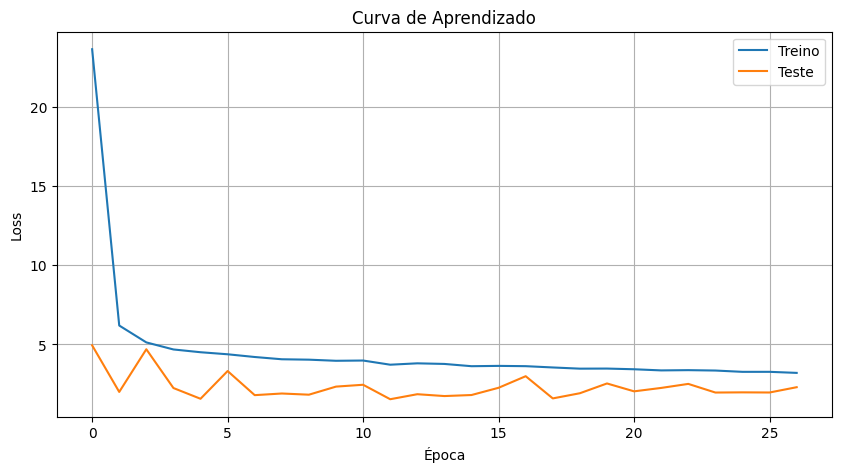

✅ Modelo completo salvo como 'melhor_modelo_completo.pth'


"\nmodelo_carregado = torch.load('melhor_modelo_completo.pth')\nmodelo_carregado.eval()\n"

In [20]:
# TREINO DO MODELO FINAL COM MELHORES PARÂMETROS + TESTE

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MELHORES PARÂMETROS
best_params = {
    'lr': 0.0012782314478058804,
    'weight_decay': 5.071206793426592e-06,
    'hidden_size': 512,
    'n_layers': 4,
    'dropout_rate': 0.15658205493421604
}

# MODELO FINAL COM MELHORES PARÂMETROS
class FinalNet(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        prev_size = 2

        for i in range(best_params['n_layers']):
            layers.extend([
                nn.Linear(prev_size, best_params['hidden_size']),
                nn.ReLU(),
                nn.Dropout(best_params['dropout_rate'])
            ])
            prev_size = best_params['hidden_size']

        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# INICIALIZAÇÃO XAVIER
def inicializar_xavier(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)

# PREPARAR DADOS (TREINO + VALIDAÇÃO JUNTOS)
x_treino_final = np.vstack([x_treino, x_val])
y_treino_final = np.hstack([y_treino, y_val])

print(f"Treino final: {x_treino_final.shape[0]} amostras")
print(f"Teste: {x_teste.shape[0]} amostras")

# Converter para tensores (nao tínhamos feito isso com o teste)
X_test_tensor = torch.tensor(x_teste, dtype=torch.float64).to(device)
y_test_tensor = torch.tensor(y_teste, dtype=torch.float64).view(-1, 1).to(device)

X_train_tensor = torch.tensor(x_treino_final, dtype=torch.float64).to(device)
y_train_tensor = torch.tensor(y_treino_final, dtype=torch.float64).view(-1, 1).to(device)

# Criar DataLoaders
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# INICIALIZAR MODELO
model = FinalNet().double().to(device)
inicializar_xavier(model)
print("\nINICIALIZAÇÃO XAVIER APLICADA")

# OTIMIZADOR E CRITÉRIO
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']  # L2 Regularization
)
criterion = nn.MSELoss()

print(f"\nMELHORES PARÂMETROS:")
print(f"  Learning Rate: {best_params['lr']}")
print(f"  Weight Decay: {best_params['weight_decay']}")
print(f"  Hidden Size: {best_params['hidden_size']}")
print(f"  N Layers: {best_params['n_layers']}")
print(f"  Dropout Rate: {best_params['dropout_rate']}")

# VERIFICAÇÃO DO LOSS INICIAL
print("\nVERIFICAÇÃO DO LOSS INICIAL")
model.eval()
with torch.no_grad():
    # Loss no treino
    y_pred_initial = model(X_train_tensor)
    initial_train_loss = criterion(y_pred_initial, y_train_tensor)
    print(f"Loss inicial (treino): {initial_train_loss.item():.6f}")

    # Loss no teste
    y_test_pred_initial = model(X_test_tensor)
    initial_test_loss = criterion(y_test_pred_initial, y_test_tensor)
    print(f"Loss inicial (teste): {initial_test_loss.item():.6f}")

# TREINAMENTO
print("\nINICIANDO TREINO FINAL")
num_epochs = 100
patience = 15
best_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # FASE DE TREINO
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # FASE DE VALIDAÇÃO (usando conjunto de teste como "validação" para early stopping)
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item() * X_batch.size(0)

        test_loss = test_loss / len(test_loader.dataset)
        val_losses.append(test_loss)

    # EARLY STOPPING
    if test_loss < best_loss:
        best_loss = test_loss
        patience_counter = 0
        # Salvar melhor modelo
        torch.save(model.state_dict(), 'melhor_modelo.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping na época {epoch + 1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch + 1:3d} | Treino: {train_loss:.6f} | Teste: {test_loss:.6f}")

# CARREGAR MELHOR MODELO
model.load_state_dict(torch.load('melhor_modelo.pth'))

# AVALIAÇÃO FINAL
print("\n" + "="*70)
print("AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")
print("="*70)

model.eval()
with torch.no_grad():
    # Previsões finais
    y_test_pred = model(X_test_tensor)
    final_test_loss = criterion(y_test_pred, y_test_tensor)

    # Calcular R² Score (acurácia para regressão)
    from sklearn.metrics import r2_score, mean_squared_error

    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_test_pred.cpu().numpy()

    r2 = r2_score(y_test_np, y_pred_np)
    mse = mean_squared_error(y_test_np, y_pred_np)
    rmse = np.sqrt(mse)

    print(f"Loss Final (MSE): {final_test_loss.item():.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R² Score: {r2:.6f}")

    # Comparação com baseline
    baseline_loss = np.mean((y_test_np - np.mean(y_test_np))**2)
    print(f"Baseline (variação total): {baseline_loss:.6f}")
    print(f"Melhoria sobre baseline: {((baseline_loss - mse) / baseline_loss * 100):.2f}%")

# RESULTADOS DO TREINO
print("\n" + "="*70)
print("RESUMO DO TREINAMENTO")
print("="*70)
print(f"Épocas treinadas: {epoch + 1}")
print(f"Melhor loss no teste: {best_loss:.6f}")
print(f"Loss final no treino: {train_loss:.6f}")

# PLOT
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Treino')
    plt.plot(val_losses, label='Teste')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Curva de Aprendizado')
    plt.legend()
    plt.grid(True)
    plt.show()
except:
    print("\nInstale matplotlib para ver o gráfico: pip install matplotlib")

# Salvar o modelo completo (arquivo maior)
torch.save(model, 'melhor_modelo_completo.pth')
print("✅ Modelo completo salvo como 'melhor_modelo_completo.pth'")

# Para carregar depois:
"""
modelo_carregado = torch.load('melhor_modelo_completo.pth')
modelo_carregado.eval()
"""

Usamos Early stopping (para evitar overfitting), além de Dropout (0.156) e L2 Regularization. Analisando as métricas, temos:

*   MSE: $1.248925$ erro bom (muito menor do que achamos em outras etapas, o que significa que encontramos bons parâmetros E hiperparâmetros para o modelo).
*   $R^2 = 99.2%$: ótima performance em dados não vistos (boa generalização), ou seja, não está overfittando (early stopping funcionou de maneira correta aqui). $R^2$ compara os resultados com um modelo que sempre prevê a média.
*   RMSE= $1.248925$: voltando à mesma unidade dos dados originais com erro médio de 1.25 unidades.

*   O único ponto de atenção é o tamanho da rede. Procurei redes com performances semelhantes com menos camadas, mas não encontrei algo que pudesse substituir os parâmetros encontrados acima.




In [21]:
from google.colab import files
files.download('melhor_modelo_completo.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ITEM C.

Refaça o **item b) da Lista 3** para essa nova rede. Comente os resultados.

> Faça um gráfico do valor observado ($y_i$) em função do valor esperado ($\hat{y}_i=E(Y_i|x_{1i}, x_{2i})$) para cada observação do conjunto de teste. Interprete o resultado.

Recuperando o código usado:



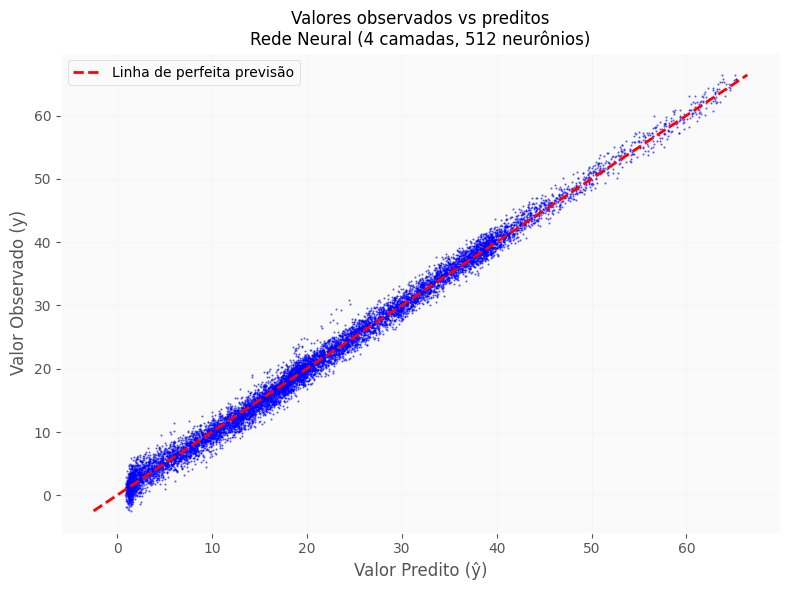


ANÁLISE DO GRÁFICO:
Correlação entre previsto e real: 0.996136
R² Score: 0.992173

Previsões dentro de 1% do desvio padrão: 9.88%
Previsões dentro de 5% do desvio padrão: 44.72%


In [24]:
# Fazer previsões no conjunto de teste
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)

    # Converter para numpy
    y_pred_np = y_test_pred.cpu().numpy().flatten()
    y_real_np = y_test_tensor.cpu().numpy().flatten()

# Criar DataFrame com resultados
resultados_teste = pd.DataFrame({
    'y_real': y_real_np,
    'y_previsto': y_pred_np
})

# Folha de estilo

plt.style.use("ggplot")
plt.rc("axes", facecolor="#fafafa", grid=True)
plt.rc("grid", color="#f0f0f0")

plt.figure(figsize=(8, 6))
plt.scatter(resultados_teste['y_previsto'], resultados_teste['y_real'],
           alpha=0.5, s=1, color='blue')

# Linha vermelha de perfeita previsão
min_val = min(resultados_teste['y_real'].min(), resultados_teste['y_previsto'].min())
max_val = max(resultados_teste['y_real'].max(), resultados_teste['y_previsto'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2,
         label='Linha de perfeita previsão')

plt.xlabel('Valor Predito (ŷ)', fontsize=12)
plt.ylabel('Valor Observado (y)', fontsize=12)
plt.title('Valores observados vs preditos\nRede Neural (4 camadas, 512 neurônios)', fontsize=12)
plt.legend()

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estatísticas adicionais para interpretação
print("\n" + "="*60)
print("ANÁLISE DO GRÁFICO:")
print("="*60)

# Calcular métricas de qualidade do ajuste
from scipy.stats import pearsonr
correlacao, _ = pearsonr(y_pred_np, y_real_np)

print(f"Correlação entre previsto e real: {correlacao:.6f}")
print(f"R² Score: {r2_score(y_real_np, y_pred_np):.6f}")

# Porcentagem dentro de margens
margem_1 = 0.01 * np.std(y_real_np)
margem_5 = 0.05 * np.std(y_real_np)
dentro_1pct = np.mean(distancias <= margem_1) * 100
dentro_5pct = np.mean(distancias <= margem_5) * 100

print(f"\nPrevisões dentro de 1% do desvio padrão: {dentro_1pct:.2f}%")
print(f"Previsões dentro de 5% do desvio padrão: {dentro_5pct:.2f}%")

Note que temos um comportamento BEM diferente do observado na lista 3:

*   Os pontos com valores preditos entre $0$ e $40$ são os que aparecem mais (maior densidade de pontos nessa região).
*   Os pontos parecem acompanhar a linha perfeita de previsão, com uma variância bem menor que o caso anterior.
*   Anteriormente tínhamos que o $y$ previsto ia apenas até aproximadamente $30$, enquanto o valor real tinha vários valores próximos a $60$, o que foi corrigido nessa outra versão do modelo.
*   A imagem também mostra evidências de baixo bias, pois os erros parecem estar distribuídos de maneira simétrica ao redor da linha vermelha (não tem uma tendência sistemática à um erro específico).




# ITEM D.

Use a função de previsão do *PyTorch* para calcular o valor predito da variável resposta, $\hat{y} = f(x_1 = 1, x_2 = 1; \theta)$, para $\theta$ definido de acordo com a rede ajustada. (Veja o item a) da Lista 2).

Segue a previsão para os valores $x_1 = 1, x_2 = 1$ usando o a rede ajustada (model) e considerando que os dados não foram normalizados. Numa primeira tentativa notamos que $x_1 = 1, x_2 = 1$ não são dados que estão no conjunto original e por isso vamos fazer uma aproximação numa vizinhança desse ponto (para capturar pontos que estão no dataset gerado inicialmente):



In [28]:
# Pevisão para x1 = 1, x2 = 1
model.eval()
with torch.no_grad():
    x_novo = torch.tensor([[1.0, 1.0]], dtype=torch.float64).to(device)

    # Fazer previsão
    y_predito = model(x_novo)
    mask = (dados['x1.obs'] == 1) & (dados['x2.obs'] == 1)
    valores_reais = dados[mask]

    print("PREVISÃO PARA x1 = 1, x2 = 1")
    print("-"*50)
    print(f"Entrada: x1 = {x_novo[0,0].item()}, x2 = {x_novo[0,1].item()}")
    print(f"Valor predito (ŷ): {y_predito.item():.6f}")
    print(valores_reais[['x1.obs', 'x2.obs', 'y']])
    print("-"*50)

    tolerancia = 0.1
    mask_proximo = (np.abs(dados['x1.obs'] - 1) <= tolerancia) & \
               (np.abs(dados['x2.obs'] - 1) <= tolerancia)

    valores_proximos = dados[mask_proximo]
    print("Valores próximos de (1,1):")
    print(valores_proximos[['x1.obs', 'x2.obs', 'y']].head(10))



PREVISÃO PARA x1 = 1, x2 = 1
--------------------------------------------------
Entrada: x1 = 1.0, x2 = 1.0
Valor predito (ŷ): 14.529345
Empty DataFrame
Columns: [x1.obs, x2.obs, y]
Index: []
--------------------------------------------------
Valores próximos de (1,1):
        x1.obs    x2.obs          y
245   1.023646  0.962878  12.517536
2813  1.040812  1.050675  15.050058
2852  1.074940  0.923175  14.982424
2935  0.992593  1.020800  16.634313
2996  1.037309  0.980435  14.021036
3897  0.955089  0.942634  13.300892
5092  1.090552  1.029826  13.253533
5195  1.071307  1.006464  13.034508
5446  1.056140  1.087104  14.231893
5942  0.996052  1.095911  16.224011


O modelo previu $\hat{y} = f(x_1 = 1, x_2 = 1; \theta) = 14.529$. Analisando os pontos nas vizinhanças de $(1,1)$ notamos que estão próximos da faixa observada.

# ITEM E.

Neste exemplo meramente didático, conhecemos a superfície que estamos estimando. Apresente, lado
a lado, a Figura 1 da Lista 2 e a superfície estimada pela sua rede neural. Para tanto, basta trocar a
variável mu pelos valores preditos pela rede. Comente os resultados.


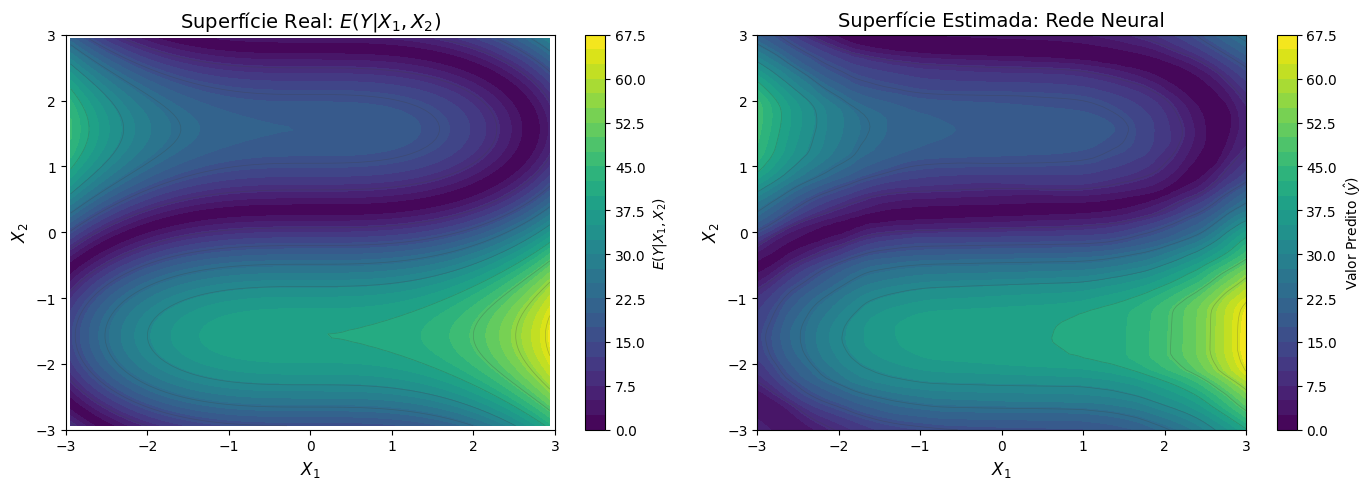

In [24]:

n = 100
x1 = np.linspace(-3, 3, n)
x2 = np.linspace(-3, 3, n)
X1, X2 = np.meshgrid(x1, x2)

# Extrair pontos e valores mu da tabela
pontos_reais = dados[['x1.obs', 'x2.obs']].values
valores_mu_reais = dados['mu'].values

# Interpolação
mu_real_interp = griddata(pontos_reais, valores_mu_reais, (X1, X2), method='linear')  # linear é mais rápido

model.eval()
with torch.no_grad():
    grid_points = np.column_stack([X1.ravel(), X2.ravel()])
    grid_tensor = torch.tensor(grid_points, dtype=torch.float64).to(device)
    y_grid_pred = model(grid_tensor)
    mu_predito = y_grid_pred.cpu().numpy().reshape(X1.shape)

# Figura
plt.figure(figsize=(14, 5))

# Superfície real
plt.subplot(1, 2, 1)
contour1 = plt.contourf(X1, X2, mu_real_interp, levels=30, cmap='viridis')
plt.contour(X1, X2, mu_real_interp, levels=8, colors='#404040', alpha=0.3, linewidths=0.5)
plt.xlabel('$X_1$', fontsize=12)
plt.ylabel('$X_2$', fontsize=12)
plt.title('Superfície Real: $E(Y|X_1, X_2)$', fontsize=14)
plt.colorbar(contour1, label='$E(Y|X_1, X_2)$')
plt.grid(False)
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# Superfície Estimada
plt.subplot(1, 2, 2)
contour2 = plt.contourf(X1, X2, mu_predito, levels=30, cmap='viridis')
plt.contour(X1, X2, mu_predito, levels=8, colors='#404040', alpha=0.3, linewidths=0.5)
plt.xlabel('$X_1$', fontsize=12)
plt.ylabel('$X_2$', fontsize=12)
plt.title('Superfície Estimada: Rede Neural', fontsize=14)
plt.colorbar(contour2, label='Valor Predito ($\\hat{y}$)')
plt.grid(False)
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.tight_layout()
plt.show()

As superfíceis estão bem próximas em termos de coloração (níveis) e formato (considerando a mesma escala). Além disso, a rede aprendeu uma função não-linear complexa sem overfittar. A rede capturou bem as mudanças graduais que acontecem ao longo da superfície apresentando um comportamente semelhante e satisfatório.

# ITEM F.

Refaça o item g) da Lista 3 para essa nova rede. Comente os resultados.

> Para o modelo linear 2, faça um gráfico de dispersão entre  e onde cada ponto corresponde a uma observação do conjunto de teste. Identifique os pontos que estavam contidos nos respectivos intervalos de confianças utilizando a cor verde. Para os demais pontos, use vermelho. Comente o resultado.

GRÁFICO DE DISPERSÃO - REDE NEURAL
Desvio padrão dos resíduos: 1.240018
Intervalo de predição 95%: ±2.430436
Pontos capturados: 9496/10000 (94.96%)
Pontos não capturados: 504/10000 (5.04%)


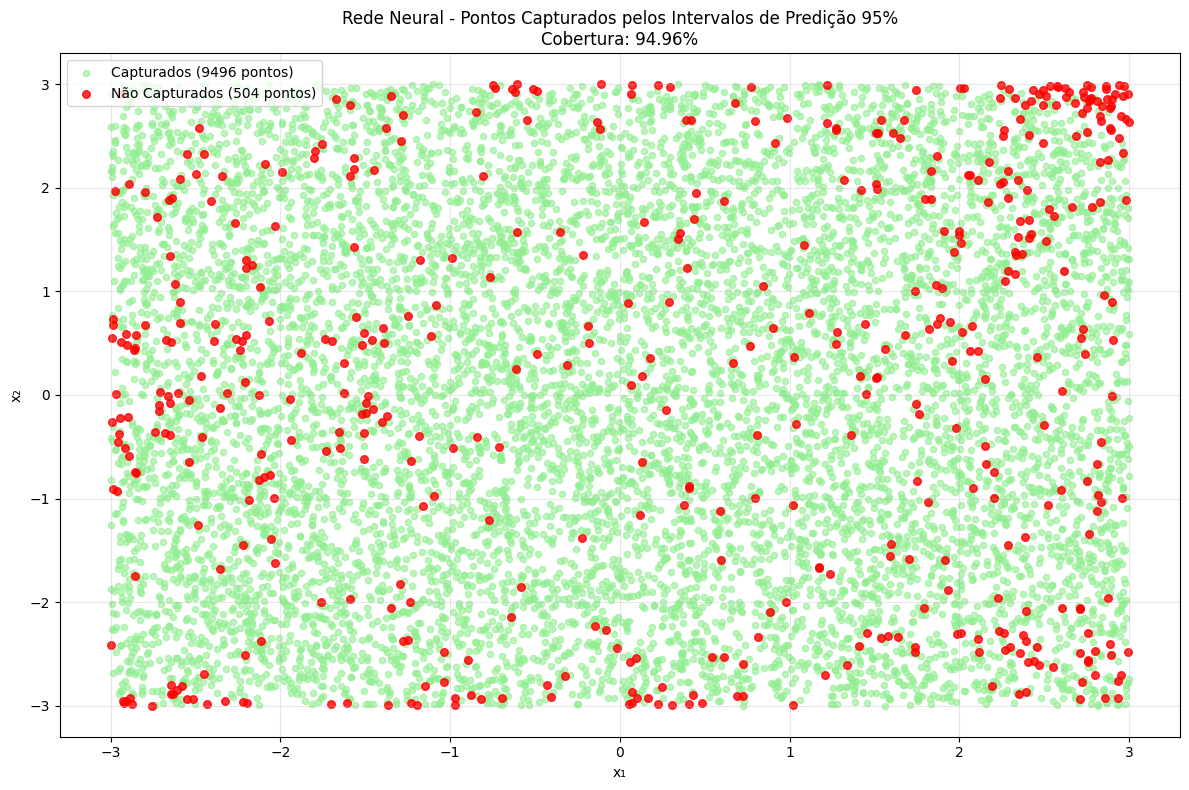


ANÁLISE POR REGIÕES
Cobertura por região:
  Q1 (x₁ baixo, x₂ baixo): 95.73% (2424/2532 pontos)
  Q2 (x₁ alto, x₂ baixo): 95.26% (2351/2468 pontos)
  Q3 (x₁ baixo, x₂ alto): 95.83% (2365/2468 pontos)
  Q4 (x₁ alto, x₂ alto): 93.05% (2356/2532 pontos)

COMPARAÇÃO COM O ESPERADO (95%):
  Cobertura observada: 94.96%
  Diferença: -0.04%


In [28]:
print("GRÁFICO DE DISPERSÃO - REDE NEURAL")

# Fazer previsões no conjunto de teste
model.eval()
with torch.no_grad():
    y_pred_teste = model(X_test_tensor).cpu().numpy().flatten()

# Calcular resíduos e intervalo de predição
residuos = y_teste - y_pred_teste
std_residuos = np.std(residuos)

# Intervalo de predição 95% (assumindo distribuição normal dos resíduos)
intervalo = 1.96 * std_residuos
lower_rn = y_pred_teste - intervalo
upper_rn = y_pred_teste + intervalo

# Identificar quais pontos foram capturados pelos intervalos
pontos_capturados = (y_teste >= lower_rn) & (y_teste <= upper_rn)
pontos_nao_capturados = ~pontos_capturados

cobertura = np.mean(pontos_capturados) * 100

print(f"Desvio padrão dos resíduos: {std_residuos:.6f}")
print(f"Intervalo de predição 95%: ±{intervalo:.6f}")
print(f"Pontos capturados: {np.sum(pontos_capturados)}/{len(y_teste)} ({cobertura:.2f}%)")
print(f"Pontos não capturados: {np.sum(pontos_nao_capturados)}/{len(y_teste)} ({100-cobertura:.2f}%)")

# Criar o gráfico de dispersão
plt.figure(figsize=(12, 8))

# Plotar pontos capturados (verde)
plt.scatter(x_teste[pontos_capturados, 0], x_teste[pontos_capturados, 1],
           c='#90EE90', alpha=0.6, s=20, label=f'Capturados ({np.sum(pontos_capturados)} pontos)')

# Plotar pontos não capturados (vermelho)
plt.scatter(x_teste[pontos_nao_capturados, 0], x_teste[pontos_nao_capturados, 1],
           c='red', alpha=0.8, s=30, label=f'Não Capturados ({np.sum(pontos_nao_capturados)} pontos)')

plt.xlabel('x₁')
plt.ylabel('x₂')
plt.title('Rede Neural - Pontos Capturados pelos Intervalos de Predição 95%\n'
          f'Cobertura: {cobertura:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Análise adicional por regiões
print("\nANÁLISE POR REGIÕES")

x1_median = np.median(x_teste[:, 0])
x2_median = np.median(x_teste[:, 1])

regioes = {
    'Q1 (x₁ baixo, x₂ baixo)': (x_teste[:, 0] < x1_median) & (x_teste[:, 1] < x2_median),
    'Q2 (x₁ alto, x₂ baixo)': (x_teste[:, 0] >= x1_median) & (x_teste[:, 1] < x2_median),
    'Q3 (x₁ baixo, x₂ alto)': (x_teste[:, 0] < x1_median) & (x_teste[:, 1] >= x2_median),
    'Q4 (x₁ alto, x₂ alto)': (x_teste[:, 0] >= x1_median) & (x_teste[:, 1] >= x2_median)
}

print("Cobertura por região:")
for regiao, mascara in regioes.items():
    if np.sum(mascara) > 0:
        cobertura_regiao = np.mean(pontos_capturados[mascara]) * 100
        n_pontos = np.sum(mascara)
        print(f"  {regiao}: {cobertura_regiao:.2f}% ({np.sum(pontos_capturados[mascara])}/{n_pontos} pontos)")

# Comparação
esperado = 95.0
diferenca_cobertura = cobertura - esperado
print(f"\nCOMPARAÇÃO COM O ESPERADO (95%):")
print(f"  Cobertura observada: {cobertura:.2f}%")
print(f"  Diferença: {diferenca_cobertura:+.2f}%")



Note que, em comparação com a figura da Lista 3, os resíduos (pontos em vermelho) estão distribuídos de maneira bem mais aleatória, ou seja, temos bem menos possíveis erros sistemáticos. De maneira geral, os erros estão distribuídos por toda a superfície. Temos alguns pontos de maior acúmulo (por exemplo, canto superior direito), mas mesmos assim a rede neural (correramente calibrada) apresenta uma performance muito melhor que a regressão 2.

# ITEM G.

Ajuste uma rede neural só com a variável $x_1$ e outra só com a variável $x_2$. Qual das duas variáveis é mais importante para o poder preditivo? Agora, com o modelo completo ajustado no item b), faça um Teste de Importância por Permutação. Comente os resultados.


## Rede ajustada apenas com x1

In [29]:
####Rede ajustada apenas com x1

print("-"*70)
print("REDE NEURAL APENAS COM x1")
print("-"*70)

class NetX1(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        prev_size = 1  # Apenas x1

        for i in range(best_params['n_layers']):
            layers.extend([
                nn.Linear(prev_size, best_params['hidden_size']),
                nn.ReLU(),
                nn.Dropout(best_params['dropout_rate'])
            ])
            prev_size = best_params['hidden_size']

        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Preparar dados apenas com x1
x_treino_x1 = x_treino_final[:, 0:1]  # Apenas x1
x_teste_x1 = x_teste[:, 0:1]

X_train_x1 = torch.tensor(x_treino_x1, dtype=torch.float64).to(device)
X_test_x1 = torch.tensor(x_teste_x1, dtype=torch.float64).to(device)

# Treinar modelo x1
model_x1 = NetX1().double().to(device)
inicializar_xavier(model_x1)
optimizer_x1 = torch.optim.Adam(model_x1.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

# Treino rápido
best_loss_x1 = float('inf')
for epoch in range(50):
    model_x1.train()
    optimizer_x1.zero_grad()
    y_pred = model_x1(X_train_x1)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer_x1.step()

    # Validação
    model_x1.eval()
    with torch.no_grad():
        y_test_pred_x1 = model_x1(X_test_x1)
        test_loss_x1 = criterion(y_test_pred_x1, y_test_tensor)

        if test_loss_x1 < best_loss_x1:
            best_loss_x1 = test_loss_x1

# Avaliação final x1
model_x1.eval()
with torch.no_grad():
    y_pred_x1 = model_x1(X_test_x1)
    r2_x1 = r2_score(y_test_tensor.cpu().numpy(), y_pred_x1.cpu().numpy())
    rmse_x1 = np.sqrt(criterion(y_pred_x1, y_test_tensor).item())

print(f"R² apenas com x1: {r2_x1:.6f}")
print(f"RMSE apenas com x1: {rmse_x1:.6f}")

----------------------------------------------------------------------
REDE NEURAL APENAS COM x1
----------------------------------------------------------------------
R² apenas com x1: 0.030974
RMSE apenas com x1: 13.896427


## Rede ajustada apenas com x2

In [30]:
# REDE NEURAL APENAS COM x2
print("\n" + "="*70)
print("REDE NEURAL APENAS COM x2")
print("="*70)

class NetX2(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        prev_size = 1  # Apenas x2

        for i in range(best_params['n_layers']):
            layers.extend([
                nn.Linear(prev_size, best_params['hidden_size']),
                nn.ReLU(),
                nn.Dropout(best_params['dropout_rate'])
            ])
            prev_size = best_params['hidden_size']

        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Preparar dados apenas com x2
x_treino_x2 = x_treino_final[:, 1:2]  # Apenas x2
x_teste_x2 = x_teste[:, 1:2]

X_train_x2 = torch.tensor(x_treino_x2, dtype=torch.float64).to(device)
X_test_x2 = torch.tensor(x_teste_x2, dtype=torch.float64).to(device)

# Treinar modelo x2
model_x2 = NetX2().double().to(device)
inicializar_xavier(model_x2)
optimizer_x2 = torch.optim.Adam(model_x2.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

# Treino rápido
best_loss_x2 = float('inf')
for epoch in range(50):
    model_x2.train()
    optimizer_x2.zero_grad()
    y_pred = model_x2(X_train_x2)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer_x2.step()

    # Validação
    model_x2.eval()
    with torch.no_grad():
        y_test_pred_x2 = model_x2(X_test_x2)
        test_loss_x2 = criterion(y_test_pred_x2, y_test_tensor)

        if test_loss_x2 < best_loss_x2:
            best_loss_x2 = test_loss_x2

# Avaliação final x2
model_x2.eval()
with torch.no_grad():
    y_pred_x2 = model_x2(X_test_x2)
    r2_x2 = r2_score(y_test_tensor.cpu().numpy(), y_pred_x2.cpu().numpy())
    rmse_x2 = np.sqrt(criterion(y_pred_x2, y_test_tensor).item())

print(f"R² apenas com x2: {r2_x2:.6f}")
print(f"RMSE apenas com x2: {rmse_x2:.6f}")


REDE NEURAL APENAS COM x2
R² apenas com x2: 0.277301
RMSE apenas com x2: 12.000908


In [34]:
# COMPARAÇÃO DAS VARIÁVEIS
print("\n" + "-"*70)
print("COMPARAÇÃO DO PODER PREDITIVO")
print("-"*70)
print(f"Modelo Completo (x1 + x2): R² = {r2:.6f}, RMSE = {rmse:.6f}")
print(f"Apenas x1:                 R² = {r2_x1:.6f}, RMSE = {rmse_x1:.6f}")
print(f"Apenas x2:                 R² = {r2_x2:.6f}, RMSE = {rmse_x2:.6f}")

# Determinar variável mais importante
if r2_x1 > r2_x2:
    print(f"x1 é MAIS importante (R²: +{(r2_x1 - r2_x2):.4f})")
else:
    print(f"x2 é MAIS importante (R²: +{(r2_x2 - r2_x1):.4f})")


----------------------------------------------------------------------
COMPARAÇÃO DO PODER PREDITIVO
----------------------------------------------------------------------
Modelo Completo (x1 + x2): R² = 0.992256, RMSE = 1.242307
Apenas x1:                 R² = 0.030974, RMSE = 13.896427
Apenas x2:                 R² = 0.277301, RMSE = 12.000908
x2 é MAIS importante (R²: +0.2463)


Analisando os resultados acima, concluímos que as duas variáveis são de importância para o modelo. Quando consideramos apenas $x_1$, o modelo tem um poder preditivo baixo em comparação à mesma situação, porém considerando apenas $x_2$ (nesse caso temos algum poder preditivo, mas não o suficiente). Logo, $x_2$ é mais importante que $x_1$, mas ambos são necessários para uma acurácia considerável.

$x_2$ sozinho tem uma variação de -30 a 30 considerando a função $30·sin(x_2)$, enquanto $x_1$ sozinho é responsável pela variação de ${x_1}^3$, que variaria de $-27$ até $27$. Aqui temos que $x_2$ controla uma parte não linear extremamente importante para a predição (senóide), mas que $x_1$ também é necessário para balancear os valores em questão.

## Teste de importância por permutação

Vamos utilizar a ideia de que se uma variável é importante, se "bagunçarmos" os valores isso vai piorar muito as previsões do modelo:

In [37]:
# TESTE DE IMPORTÂNCIA POR PERMUTAÇÃO
print("\n" + "="*70)
print("TESTE DE IMPORTÂNCIA POR PERMUTAÇÃO")
print("="*70)

def permutation_importance(model, X, y, n_permutations=100, random_seed=42):
    """Calcula importância por permutação com seed fixa"""
    # Definir seed para reproducibilidade
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    model.eval()
    with torch.no_grad():
        # Performance baseline
        y_pred = model(X)
        baseline_score = r2_score(y.cpu().numpy(), y_pred.cpu().numpy())

        importance_scores = []

        for feature_idx in range(X.shape[1]):
            feature_scores = []

            for perm_idx in range(n_permutations):
                # Usar seed específica para cada permutação
                current_seed = random_seed + feature_idx * n_permutations + perm_idx
                torch.manual_seed(current_seed)

                X_permuted = X.clone()
                # Permutar a feature
                perm_indices = torch.randperm(X.shape[0])
                X_permuted[:, feature_idx] = X[perm_indices, feature_idx]

                # Calcular score com feature permutada
                y_pred_perm = model(X_permuted)
                perm_score = r2_score(y.cpu().numpy(), y_pred_perm.cpu().numpy())
                feature_scores.append(perm_score)

            # Importância = quanto piora o desempenho
            importance = baseline_score - np.mean(feature_scores)
            importance_scores.append(importance)

            print(f"  Feature {feature_idx+1}: baseline={baseline_score:.4f}, permutado={np.mean(feature_scores):.4f}, importância={importance:.4f}")

    return importance_scores

# Calcular importância por permutação
print("Calculando importância por permutação...")
importance_scores = permutation_importance(model, X_test_tensor, y_test_tensor, n_permutations=50, random_seed=42)

print("\n" + "-"*50)
print("RESULTADOS FINAIS:")
print("-"*50)
print("Importância por Permutação (quanto maior, mais importante):")
print(f"x1: {importance_scores[0]:.6f}")
print(f"x2: {importance_scores[1]:.6f}")

if importance_scores[0] > importance_scores[1]:
    print(f"POR PERMUTAÇÃO: x1 é MAIS importante (diferença: {importance_scores[0]-importance_scores[1]:.4f})")
else:
    print(f"POR PERMUTAÇÃO: x2 é MAIS importante (diferença: {importance_scores[1]-importance_scores[0]:.4f})")




TESTE DE IMPORTÂNCIA POR PERMUTAÇÃO
Calculando importância por permutação...
  Feature 1: baseline=0.9923, permutado=0.1463, importância=0.8460
  Feature 2: baseline=0.9923, permutado=-0.8936, importância=1.8859

--------------------------------------------------
RESULTADOS FINAIS:
--------------------------------------------------
Importância por Permutação (quanto maior, mais importante):
x1: 0.845958
x2: 1.885856
POR PERMUTAÇÃO: x2 é MAIS importante (diferença: 1.0399)


Como tínhamos cobservado anteriormente, entre as duas variáveis disponíveis $x_2$ é a mais imporante quando usamos o teste de permutação.

# ITEM H.

Construa uma nova rede, agora ajustada sobre os valores previstos (ao invés dos valores observados de $y$) para cada observação dos conjuntos de treinamento e validação. Use a arquitetura mais parcimoniosa que conseguir, sem comprometer substancialmente o poder de previsão da rede (quando comparada à obtida no item 2b). Cite um possível uso para essa nova rede.

Essa nova rede será treinada com os mesmos valores de entrada, mas tendo como saída os **valores previstos da rede anterior**.

## Otimização de Hiperparâmetros para a REDE2 (Meta)

In [45]:
print("INICIANDO OTIMIZAÇÃO PARA REDE META")
print("="*70)

# Verificar a escala dos dados
model.eval()
with torch.no_grad():
    y_previsto_treino = model(torch.tensor(x_treino, dtype=torch.float64).to(device)).cpu().numpy().flatten()
    y_previsto_val = model(torch.tensor(x_val, dtype=torch.float64).to(device)).cpu().numpy().flatten()

print("ESCALA DOS DADOS:")
print(f"x_treino - Min: {x_treino.min():.2f}, Max: {x_treino.max():.2f}")
print(f"y_previsto_treino - Min: {y_previsto_treino.min():.2f}, Max: {y_previsto_treino.max():.2f}")
print(f"y_previsto_treino - Média: {y_previsto_treino.mean():.2f}, Std: {y_previsto_treino.std():.2f}")

print("\nNORMALIZAR OS DADOS")
print("-"*70)

from sklearn.preprocessing import StandardScaler

# Normalizar os valores previstos
scaler_y_meta = StandardScaler()
y_previsto_treino_norm = scaler_y_meta.fit_transform(y_previsto_treino.reshape(-1, 1)).flatten()
y_previsto_val_norm = scaler_y_meta.transform(y_previsto_val.reshape(-1, 1)).flatten()

print("APÓS NORMALIZAÇÃO:")
print(f"y_previsto_treino_norm - Min: {y_previsto_treino_norm.min():.2f}, Max: {y_previsto_treino_norm.max():.2f}")
print(f"y_previsto_treino_norm - Média: {y_previsto_treino_norm.mean():.2f}, Std: {y_previsto_treino_norm.std():.2f}")

def objective_meta_normalizada(trial):
    # HIPERPARÂMETROS PARA DADOS NORMALIZADOS
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-4, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64])
    n_layers = trial.suggest_int('n_layers', 1, 2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class SimpleNet(nn.Module):
        def __init__(self, input_size=2, hidden_size=hidden_size, n_layers=n_layers, dropout_rate=dropout_rate):
            super().__init__()
            layers = []
            prev_size = input_size

            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            for i in range(n_layers - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.ReLU())
                if dropout_rate > 0:
                    layers.append(nn.Dropout(dropout_rate))

            layers.append(nn.Linear(hidden_size, 1))
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # TREINAR COM DADOS NORMALIZADOS
    model_meta = SimpleNet().double().to(device)

    X_tensor = torch.tensor(x_treino, dtype=torch.float64).to(device)
    y_tensor = torch.tensor(y_previsto_treino_norm, dtype=torch.float64).view(-1, 1).to(device)  # NORMALIZADO!
    X_val_tensor = torch.tensor(x_val, dtype=torch.float64).to(device)
    y_val_tensor = torch.tensor(y_previsto_val_norm, dtype=torch.float64).view(-1, 1).to(device)  # NORMALIZADO!

    optimizer = torch.optim.Adam(model_meta.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')

    for epoch in range(30):
        model_meta.train()
        optimizer.zero_grad()
        y_pred = model_meta(X_tensor)
        loss = criterion(y_pred, y_tensor)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model_meta.eval()
            with torch.no_grad():
                y_val_pred = model_meta(X_val_tensor)
                val_loss = criterion(y_val_pred, y_val_tensor)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss

    return best_val_loss.item()

# EXECUTAR OTIMIZAÇÃO NORMALIZADA
study_meta_normalizada = optuna.create_study(direction='minimize')
study_meta_normalizada.optimize(objective_meta_normalizada, n_trials=10, show_progress_bar=True)

print(f"\nMELHOR LOSS NORMALIZADA: {study_meta_normalizada.best_value:.6f}")

# TREINAR REDE META FINAL NORMALIZADA
print("\nTREINANDO REDE META FINAL")

best_meta_params = study_meta_normalizada.best_params
print("Melhores parâmetros:", best_meta_params)

class FinalMetaNet(nn.Module):
    def __init__(self, hidden_size=best_meta_params['hidden_size'],
                 n_layers=best_meta_params['n_layers'],
                 dropout_rate=best_meta_params['dropout_rate']):
        super().__init__()
        layers = []
        prev_size = 2

        layers.append(nn.Linear(prev_size, hidden_size))
        layers.append(nn.ReLU())
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        for i in range(n_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Dados completos normalizados
x_meta_final = np.vstack([x_treino, x_val])
y_meta_final_norm = np.hstack([y_previsto_treino_norm, y_previsto_val_norm])

X_meta_tensor = torch.tensor(x_meta_final, dtype=torch.float64).to(device)
y_meta_tensor_norm = torch.tensor(y_meta_final_norm, dtype=torch.float64).view(-1, 1).to(device)

meta_model_final = FinalMetaNet().double().to(device)
meta_optimizer = torch.optim.Adam(meta_model_final.parameters(),
                                 lr=best_meta_params['lr'],
                                 weight_decay=best_meta_params['weight_decay'])

# Treino final
for epoch in range(50):
    meta_model_final.train()
    meta_optimizer.zero_grad()
    y_pred_norm = meta_model_final(X_meta_tensor)
    loss = criterion(y_pred_norm, y_meta_tensor_norm)
    loss.backward()
    meta_optimizer.step()

# AVALIAÇÃO FINAL
meta_model_final.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(x_teste, dtype=torch.float64).to(device)

    # Previsões da rede meta (desnormalizar)
    y_meta_pred_norm = meta_model_final(X_test_tensor)
    y_meta_pred = scaler_y_meta.inverse_transform(y_meta_pred_norm.cpu().numpy()).flatten()

    # Previsões do modelo original para comparação
    y_previsto_teste = model(X_test_tensor).cpu().numpy().flatten()

    # Calcular métricas
    r2_meta = r2_score(y_previsto_teste, y_meta_pred)
    mse_meta = mean_squared_error(y_previsto_teste, y_meta_pred)

print(f"\nRESULTADO FINAL REDE META:")
print(f"R² vs Previsões Originais: {r2_meta:.6f}")
print(f"MSE: {mse_meta:.6f}")

# MOSTRAR APENAS OS HIPERPARÂMETROS
print("\n" + "="*70)
print("HIPERPARÂMETROS ESCOLHIDOS PARA REDE META")
print("="*70)

print(f"Learning Rate: {best_meta_params['lr']:.6f}")
print(f"Weight Decay: {best_meta_params['weight_decay']:.6f}")
print(f"Hidden Size: {best_meta_params['hidden_size']}")
print(f"N Layers: {best_meta_params['n_layers']}")
print(f"Dropout Rate: {best_meta_params['dropout_rate']:.6f}")

# Salvar rede meta
torch.save(meta_model_final.state_dict(), 'rede_meta_normalizada.pth')
print(f"\nRede meta salva: 'rede_meta_normalizada.pth'")

INICIANDO OTIMIZAÇÃO PARA REDE META


[I 2025-11-23 19:20:35,975] A new study created in memory with name: no-name-09a8f84f-97c8-48fc-9d15-6a96085a54c7


ESCALA DOS DADOS:
x_treino - Min: -3.00, Max: 3.00
y_previsto_treino - Min: 0.97, Max: 66.61
y_previsto_treino - Média: 21.78, Std: 14.13

NORMALIZAR OS DADOS
----------------------------------------------------------------------
APÓS NORMALIZAÇÃO:
y_previsto_treino_norm - Min: -1.47, Max: 3.17
y_previsto_treino_norm - Média: 0.00, Std: 1.00


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-11-23 19:20:36,504] Trial 0 finished with value: 0.7923099673472985 and parameters: {'lr': 0.00023738073179826015, 'weight_decay': 2.4674185977948493e-06, 'hidden_size': 64, 'n_layers': 2, 'dropout_rate': 0.062081503817747775}. Best is trial 0 with value: 0.7923099673472985.
[I 2025-11-23 19:20:36,779] Trial 1 finished with value: 0.5770825596847868 and parameters: {'lr': 0.0041356830166857, 'weight_decay': 7.669748708879577e-07, 'hidden_size': 16, 'n_layers': 2, 'dropout_rate': 0.008568223091556804}. Best is trial 1 with value: 0.5770825596847868.
[I 2025-11-23 19:20:37,294] Trial 2 finished with value: 0.48761428534492757 and parameters: {'lr': 0.0007328399140336492, 'weight_decay': 8.771231001180325e-06, 'hidden_size': 64, 'n_layers': 2, 'dropout_rate': 0.0472433379613172}. Best is trial 2 with value: 0.48761428534492757.
[I 2025-11-23 19:20:37,427] Trial 3 finished with value: 0.5038361198161727 and parameters: {'lr': 0.005687448989415972, 'weight_decay': 2.199848695135722e

Note que o tempo da otimização dos hiperparâmetros para essa nova rede foi MUITO menor que a rede anterior e conseguimos valores bons de loss no conjunto de teste: $10$ (considerando a perda não normalizada). Imagino que esse tipo de rede, por ser mais rápida, "usa o treinamento" da rede anterior para uma abordagem mais rápida em caso de "Concept Drift", por exemplo. A velocidade de inferência é bem maior, é um processo que facilita uma possível automatização (sem que exija um profissional sempre que algo mudar em tempo real nos dados). Ele pode oferecer uma possibilidade de monitoramente mais contínuo, caso necessário.

Além disso, $R^2$ vs Previsões Originais: $0.948551$ é resultado bom que indica que a rede mais simples consegue reproduzir  $94.86%$ das previsões do modelo mais complexo. Outro ponto positivo de se trabalhar com essa rede é o fato dela ser bem mais simples (mais rápida) e apresentar um poder preditivo satisfatório:




```
Learning Rate: 0.000733
Weight Decay: 0.000009
Hidden Size: 64
N Layers: 2
Dropout Rate: 0.047243
```

